# Curation of new reference data

The following is a description of how new field and airborne lidar are prepared for GEDI Level-4a-like biomass modeling. FAO forest inventory plots in Ghana are used as an example.

The process is divided into the following 3 steps:
1. Preparing plot geometry to fit with GEDI footprint size
2. Estimating tree- and plot-level aboveground biomass density (AGBD)
3. Processing airborne lidar over plots simulate GEDI footprints and link to plot-level AGBD estimates

This resource was developed through the project “Global Transformation of Forests for People and Climate: A Focus on West Africa”; implemented by the Food and Agriculture Organization of the United Nations in partnership with the Economic Community of West African States, the University of Maryland, the University of Oxford, the  Forestry Research Institute of Ghana (FORIG)]; and with financial support from the Swedish International Development Cooperation Agency. 

**Notebook authors:**
David Minor, Geographical Sciences, University of Maryland (minord@umd.edu)
Dr. Laura Duncanson, Geographical Sciences, University of Maryland (lduncans@umd.edu)

Notebooks were developed at the University of Maryland, College Park, through expansion of existing NASA Global Ecosystem Dynamics Investigation (GEDI) mission activities.

*Code is an expansion of GEDI database activities based at the University of Maryland, developed by Dr. John Armston and managed by David Minor under the supervision of Drs. Duncanson, Armston and GEDI PI Dr. Ralph Dubayah.*

**Data Collection:**
Field data were collected and curated by FORIG.

Contact: Dr. Stephen Adu-Bredu, sabredu@csir-forig.org.gh

UAV Lidar data were collected by Oxford University.

Contact: Dr. Jesús Aguirre Gutiérrez, jesus.aguirregutierrez@ouce.ox.ac.uk

## 1. Preparing plot geometry to fit with GEDI footprint size


Load necessary R packages, and read in CSV of plot location information. This would be a csv typically provided by field teams with tree and plot data included.

In [1]:
library(terra)
library(BIOMASS)
library(ggplot2)

terra 1.7.78

Using temporary cache
  It is recommended to use a permanent cache to avoid to re-download files on each session.
  See function createCache() or BIOMASS.cache option.



In [2]:
plotdata <- read.csv("/projects/shared-buckets/minord/data/ghana_fao/plotData.csv")
colnames(plotdata)[1] <- "Site"
str(plotdata)

'data.frame':	152 obs. of  5 variables:
 $ Site     : chr  "MNP-01" "MNP-02" "MNP-03" "MNP-01" ...
 $ N        : num  9.28 9.26 9.3 9.28 9.26 ...
 $ W        : num  1.86 1.84 1.86 1.86 1.84 ...
 $ Elevation: int  138 180 146 137 178 146 137 174 147 138 ...
 $ Corner   : chr  "000 000" "000 000" "000 000" "100 000" ...


Load functions that will be used for manipulation of plot coordinates and geometry

In [3]:
## create plot geometry from corner coordinates
write.p.geom <- function(nw.x, nw.y, ne.x, ne.y, sw.x, sw.y, se.x, se.y){
	poly <- as.character(paste('POLYGON((', sw.x, sw.y, ',',
								nw.x, nw.y, ',',
								ne.x, ne.y, ',',
								se.x, se.y, ',',
								sw.x, sw.y, '))', sep = ' '))
	p.geom <- terra::vect(poly, 'polygons')
	p.geom <- terra::geom(p.geom, wkt=TRUE)
	return(p.geom)
}

## Convert coordinates from latitude and longitude to universal transverse mercator
geo2utm <- function(lon,lat) {
  d <- data.frame(lon=lon, lat=lat)
  d <- vect(d, geom = c("lon", "lat"), crs = "EPSG:4326")
  utmepsg <- get_utmwgs84_epsg(lon,lat)
  d <- project(d, paste("EPSG",utmepsg,sep=":"))
  crds(d)
}

## determine UTM/WGS84 epsg code to use for a plot location
get_utmwgs84_epsg <- function(longitude,latitude) {
  utmzone <- ( floor( (longitude + 180) / 6 ) %% 60 ) + 1
  epsg_base <- ifelse(latitude < 0, 32700, 32600)
  epsg <- epsg_base + utmzone
  epsg
}

## Convert coordinates from given EPSG to latitude and longitude
epsg2geo <- function(x,y,epsg) {
  d <- data.frame(x=x, y=y)
  d <- vect(d, geom = c("x", "y"), crs = paste0("EPSG:",epsg))  
  d <- project(d, "EPSG:4326")
  crds(d)
}

## Rotates x,y points by the given angle in degrees
## Translation to origin assumed
rotate2D <- function(x, y, phi, xt=0, yt=0) {
  phi <- phi*pi/180
  xr <- ( x * cos(phi) + y * sin(phi) ) + xt
  yr <- ( y * cos(phi) - x * sin(phi) ) + yt
  list(x=xr, y=yr)
}

#### Add corrections to plot coordinates
It is very important to be in contact with the team the collected plot data in the field to gain first-hand knowledge of field methods. In the process of collecting, recording, and transferring data there are multiple opportunities for errors to be introduced, and the field team is best equipped to address any questions that are introduced.

In this case, there were some errors in plot corner coordinates recorded from the GPS, and the field team was able to check records, and make new measurements to correct the coordinates. It is very common for errors to exist in field datasets, especially from remote locations, as field data collection is laborious and there are many opportunities for mistakes, e.g. in locations of plot, data transcription etc. 

In [4]:
plotdata$N.corr <- plotdata$N
plotdata$W.corr <- plotdata$W

plotdata$N.corr[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"] <- plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"]
plotdata$W.corr[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"] <- plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"]
plotdata$N.corr[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"] <- plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"]
plotdata$W.corr[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"] <- plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"]

plotdata$N.corr[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"] <- plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"]
plotdata$W.corr[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"] <- plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"]
plotdata$N.corr[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"] <- plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"]
plotdata$W.corr[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"] <- plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"]

plotdata$N.corr[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"] <- plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"]
plotdata$W.corr[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"] <- plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"]
plotdata$N.corr[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"] <- plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"]
plotdata$W.corr[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"] <- plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"]

plotdata$N.corr[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"] <- plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"]
plotdata$W.corr[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"] <- plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"]
plotdata$N.corr[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"] <- plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"]
plotdata$W.corr[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"] <- plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"]

plotdata$N.corr[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"] <- plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"]
plotdata$W.corr[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"] <- plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"]
plotdata$N.corr[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"] <- plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"]
plotdata$W.corr[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"] <- plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"] 

In [5]:
plotdata$N[plotdata$Site=='UTF-01' & plotdata$Corner=="000 000"] <- 11.01426
plotdata$W[plotdata$Site=='UTF-01' & plotdata$Corner=="000 000"] <- 0.20032
plotdata$N[plotdata$Site=='UTF-01' & plotdata$Corner=="000 100"] <- 11.01406
plotdata$W[plotdata$Site=='UTF-01' & plotdata$Corner=="000 100"] <- 0.19949

plotdata$N[plotdata$Site=='UTF-03' & plotdata$Corner=="000 000"] <- 11.01715
plotdata$W[plotdata$Site=='UTF-03' & plotdata$Corner=="000 100"] <- 0.19558

plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"] <- 6.704415
plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="000 000"] <- 1.31857
plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"] <- 6.7052
plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="100 000"] <- 1.31862
plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="100 100"] <- 6.70503
plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="100 100"] <- 1.31964
plotdata$N[plotdata$Site=='BOB-02' & plotdata$Corner=="000 100"] <- 6.7042033
plotdata$W[plotdata$Site=='BOB-02' & plotdata$Corner=="000 100"] <- 1.31944

plotdata$N[plotdata$Site=='BOB-04' & plotdata$Corner=="000 000"] <- 6.69048
plotdata$W[plotdata$Site=='BOB-04' & plotdata$Corner=="000 000"] <- 1.31745
plotdata$N[plotdata$Site=='BOB-04' & plotdata$Corner=="100 000"] <- 6.6905
plotdata$W[plotdata$Site=='BOB-04' & plotdata$Corner=="100 000"] <- 1.3165
plotdata$N[plotdata$Site=='BOB-04' & plotdata$Corner=="100 100"] <- 6.69145
plotdata$W[plotdata$Site=='BOB-04' & plotdata$Corner=="100 100"] <- 1.31656
plotdata$N[plotdata$Site=='BOB-04' & plotdata$Corner=="000 100"] <- 6.69141
plotdata$W[plotdata$Site=='BOB-04' & plotdata$Corner=="000 100"] <- 1.31764

plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"] <- 5.56703
plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="000 000"] <- 1.29226
plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"] <- 5.56731
plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="100 000"] <- 1.29708
plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="100 100"] <- 5.56793
plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="100 100"] <- 1.29180
plotdata$N[plotdata$Site=='KCA-01' & plotdata$Corner=="000 100"] <- 5.56707
plotdata$W[plotdata$Site=='KCA-01' & plotdata$Corner=="000 100"] <- 1.29215

plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"] <- 5.56714
plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="000 000"] <- 1.29543
plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"] <- 5.56726
plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="100 000"] <- 1.29546
plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="100 100"] <- 5.56817
plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="100 100"] <- 1.29462
plotdata$N[plotdata$Site=='KCA-02' & plotdata$Corner=="000 100"] <- 5.56807
plotdata$W[plotdata$Site=='KCA-02' & plotdata$Corner=="000 100"] <- 1.29545

plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"] <- 5.56419
plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="000 000"] <- 1.298
plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"] <- 5.56356
plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="100 000"] <- 1.2973
plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="100 100"] <- 5.56421
plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="100 100"] <- 1.2968
plotdata$N[plotdata$Site=='KCA-03' & plotdata$Corner=="000 100"] <- 5.6476
plotdata$W[plotdata$Site=='KCA-03' & plotdata$Corner=="000 100"] <- 1.29743

plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"] <- 5.56978
plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="000 000"] <- 1.37034
plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"] <- 5.56988
plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="100 000"] <- 1.36924
plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="100 100"] <- 5.57074
plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="100 100"] <- 1.36931
plotdata$N[plotdata$Site=='KCA-04' & plotdata$Corner=="000 100"] <- 5.57073
plotdata$W[plotdata$Site=='KCA-04' & plotdata$Corner=="000 100"] <- 1.37025

Convert plot coordinates from longitude and latitude to UTM, so that coordinates are in meters.
Working in meters allows for easier checking of the plot size and shape.

In [6]:
utmcoord <- t(mapply(geo2utm, -plotdata$W, plotdata$N))
utmcoord.corr <- t(mapply(geo2utm, -plotdata$W.corr, plotdata$N.corr))

colnames(utmcoord) <- c("utm.x", "utm.y")
colnames(utmcoord.corr) <- c("utm.x.corr", "utm.y.corr")

plotdata <- cbind(plotdata,utmcoord,utmcoord.corr)

In [7]:
# Reshape the data frame so that each plot has one line.
plotdata <- reshape(plotdata, idvar="Site", timevar="Corner", direction="wide")

Create the plot geometries as Well Known Text strings using the corner coordinates. Here we are creating geometries before and after the coordinate corrections above for illustration purposes.
Plot SHR-01 is created separately because it is a smaller plot.

In [8]:
ii <- plotdata$Site!="SHR-01"
plotdata$p.geom[ii] <- mapply(write.p.geom, plotdata$`utm.x.000 000`[ii], plotdata$`utm.y.000 000`[ii],
					plotdata$`utm.x.100 000`[ii], plotdata$`utm.y.100 000`[ii],
					plotdata$`utm.x.000 100`[ii], plotdata$`utm.y.000 100`[ii],
					plotdata$`utm.x.100 100`[ii], plotdata$`utm.y.100 100`[ii])

plotdata$p.geom.corr[ii] <- mapply(write.p.geom, plotdata$`utm.x.corr.000 000`[ii], plotdata$`utm.y.corr.000 000`[ii],
					plotdata$`utm.x.corr.100 000`[ii], plotdata$`utm.y.corr.100 000`[ii],
					plotdata$`utm.x.corr.000 100`[ii], plotdata$`utm.y.corr.000 100`[ii],
					plotdata$`utm.x.corr.100 100`[ii], plotdata$`utm.y.corr.100 100`[ii])

ii <- plotdata$Site=="SHR-01"
plotdata$p.geom[ii] <- write.p.geom(plotdata$`utm.x.000 000`[ii], plotdata$`utm.y.000 000`[ii],
					plotdata$`utm.x.100 000`[ii], plotdata$`utm.y.100 000`[ii],
					plotdata$`utm.x.000 020`[ii], plotdata$`utm.y.000 020`[ii],
					plotdata$`utm.x.100 020`[ii], plotdata$`utm.y.100 020`[ii])

plotdata$p.geom.corr[ii] <- write.p.geom(plotdata$`utm.x.corr.000 000`[ii], plotdata$`utm.y.corr.000 000`[ii],
					plotdata$`utm.x.corr.100 000`[ii], plotdata$`utm.y.corr.100 000`[ii],
					plotdata$`utm.x.corr.000 020`[ii], plotdata$`utm.y.corr.000 020`[ii],
					plotdata$`utm.x.corr.100 020`[ii], plotdata$`utm.y.corr.100 020`[ii])

Example of a Well Known Text plot geometry string

In [9]:
plotdata$p.geom.corr[1]

[1] "POLYGON ((624587.816789 1025736.406742, 624681.270099 1025711.271597, 624708.432161 1025805.352013, 624612.767935 1025834.903237, 624587.816789 1025736.406742))"

---

#### Shape of each plot before coordinate correction. 
Note that most of the plots are square, or close to square in shape, but some plots are greatly skewed or a plot outline that is twisted. This suggests errors in the plot geometries that should be checked with the field teams.

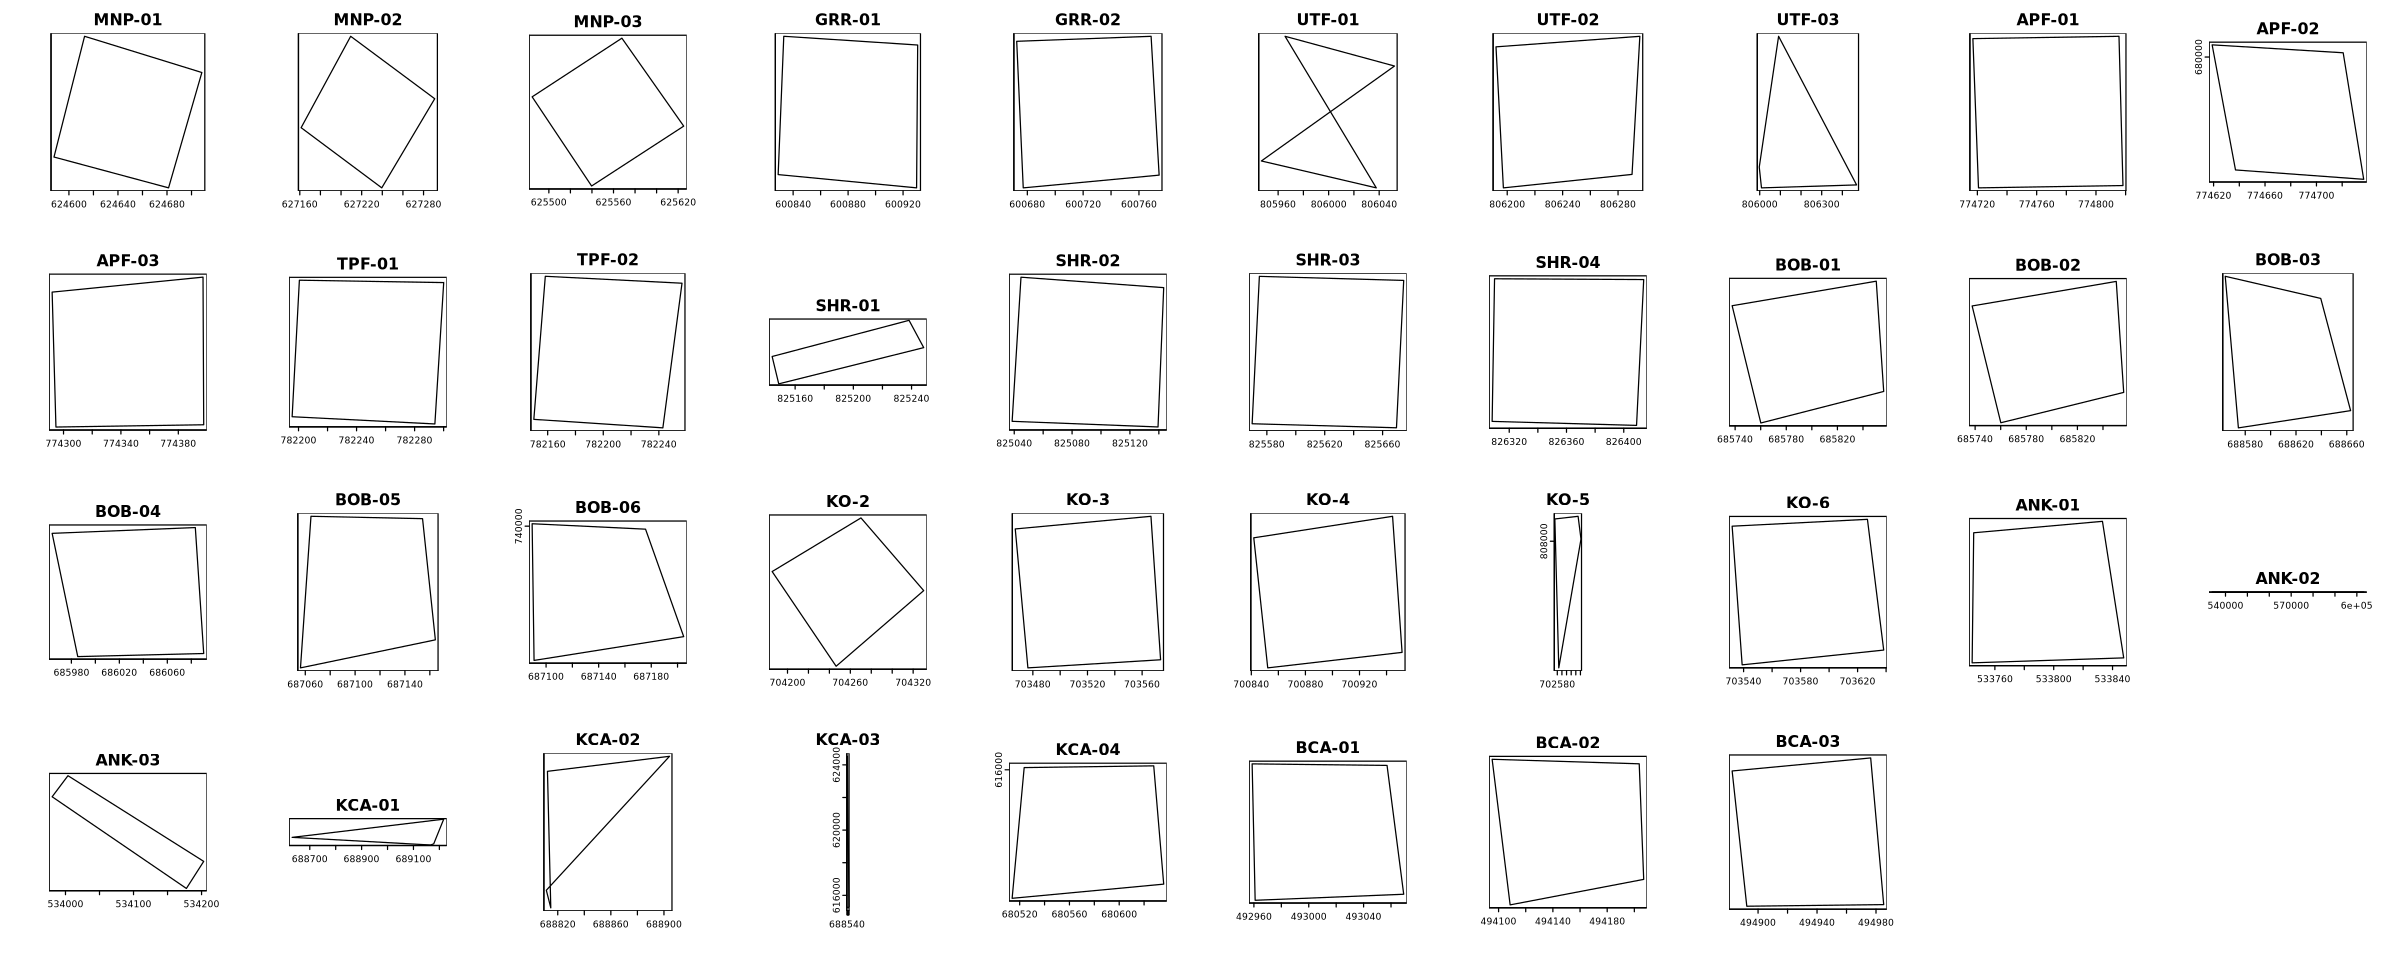

In [10]:
par(mfrow=c(4,10))
options(repr.plot.width=20, repr.plot.height=8)

for(i in 1:nrow(plotdata)){
    plot(vect(plotdata$p.geom[i]), main=plotdata$Site[i])
}

---

#### Shape of each plot after coordinate correction. 
Note the plot KO-5 and ANK-02 have not been corrected. These plots will be excluded from analysis until the field team can remeasure coordinates.

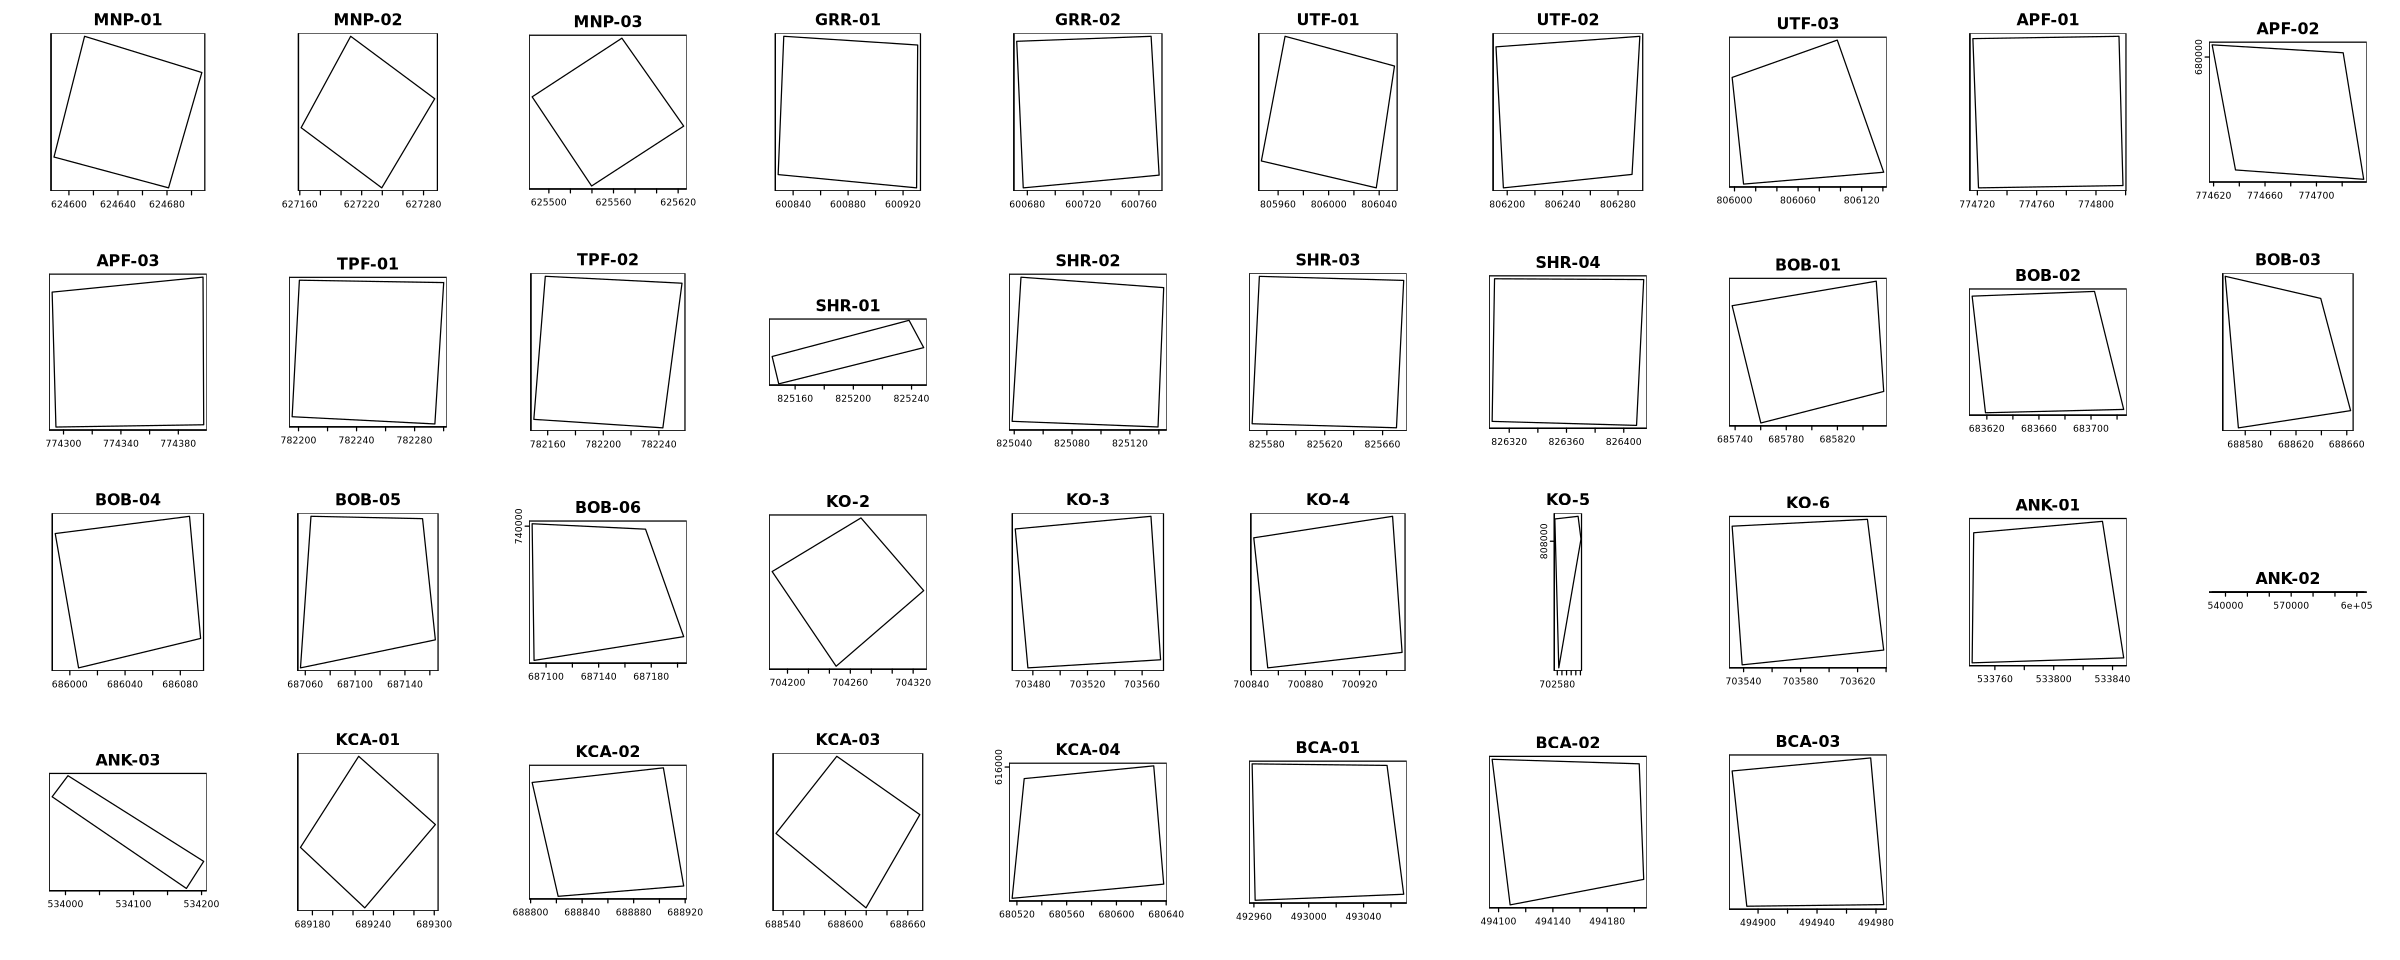

In [11]:
par(mfrow=c(4,10))
options(repr.plot.width=20, repr.plot.height=8)

for(i in 1:nrow(plotdata)){
    plot(vect(plotdata$p.geom.corr[i]), main=plotdata$Site[i])
}

#### Now that the exterior plot geometries have been established, the subplot geometries will be established. 
Subplots are 20m x 20m in size - a good match for GEDI's 25m diameter footprint. While some of the plot geometries are not truly square, based on the measured coordinates, subplots will be be treated as truly square, aligned with the mean orientation of the plot and the plot centroid

First, the plot orientation is calculated. The mean angle of the sides was used.


In [12]:
for(i in 1:nrow(plotdata)){
	theta1 <- atan((plotdata$`utm.x.corr.000 000`[i] - plotdata$`utm.x.corr.100 000`[i]) / (plotdata$`utm.y.corr.000 000`[i] - plotdata$`utm.y.corr.100 000`[i]))*180/pi
	theta2 <- atan((plotdata$`utm.x.corr.100 000`[i] - plotdata$`utm.x.corr.100 100`[i]) / (plotdata$`utm.y.corr.100 000`[i] - plotdata$`utm.y.corr.100 100`[i]))*180/pi - 90
	if(i %in% c(36,37)){
		theta2 <- atan((plotdata$`utm.x.corr.100 000`[i] - plotdata$`utm.x.corr.100 100`[i]) / (plotdata$`utm.y.corr.100 000`[i] - plotdata$`utm.y.corr.100 100`[i]))*180/pi + 90
	}

	theta3 <- atan((plotdata$`utm.x.corr.000 100`[i] - plotdata$`utm.x.corr.100 100`[i]) / (plotdata$`utm.y.corr.000 100`[i] - plotdata$`utm.y.corr.100 100`[i]))*180/pi
	if(i %in% c(20, 22, 23)){
		theta3 <- atan((plotdata$`utm.x.corr.000 100`[i] - plotdata$`utm.x.corr.100 100`[i]) / (plotdata$`utm.y.corr.000 100`[i] - plotdata$`utm.y.corr.100 100`[i]))*180/pi -180
	}
	theta4 <- atan((plotdata$`utm.x.corr.000 100`[i] - plotdata$`utm.x.corr.000 000`[i]) / (plotdata$`utm.y.corr.000 100`[i] - plotdata$`utm.y.corr.000 000`[i]))*180/pi - 90

	plotdata$p.orientation[i] <- mean(c(theta1, theta2, theta3, theta4), na.rm=T)
}

orientation.adjust <- c(-180, -90, -180, -180, 90, 
	-90, -180, 0, -180, -90,
	 -180, -90, -90, -90, -90,
	 -90, -90, 90, -180, -90,
	 -90, -90, -90, -180, -180,
	 -180, -180, -180, 0, 0,
	 0, 0, -180, -90, -180, 
	90, -180, -180)

plotdata$p.orientation <- plotdata$p.orientation + orientation.adjust

#### Calculate the centroid coordinate for each plot

In [13]:
centroid <- t(sapply(plotdata$p.geom.corr, function(x){geom(centroids(vect(x)))}, simplify=T))[,3:4]

colnames(centroid) <- c("utm.x.cent", "utm.y.cent")

latlong.centroid <- t(mapply(epsg2geo, centroid[,"utm.x.cent"], centroid[,"utm.y.cent"], 32630))
colnames(latlong.centroid) <- c("lon.cent", "lat.cent")

plotdata <- cbind(plotdata, centroid, latlong.centroid)


#### Expand the plot data frame to have a line for each subplot
The subplot numbering varies by plot, due to variation in field techniques. A look-up table of coordinates is used to assignt subplot number correctly, so that the subplot assingment matches the tree data.

In [14]:
sp <- rep(1:25, nrow(plotdata))
Site <- rep(plotdata$Site, each=25)

sp.plotdata <- as.data.frame(cbind(Site, sp))
sp.plotdata$sp <- as.numeric(sp.plotdata$sp)
sp.plotdata <- sp.plotdata[!(sp.plotdata$Site=='SHR-01' & sp.plotdata$sp>5),]
sp.plotdata <- sp.plotdata[!(sp.plotdata$Site=='ANK-03' & sp.plotdata$sp>24),]
plotdata <- dplyr::right_join(plotdata, sp.plotdata, by ="Site")


In [15]:
sp.coords <- expand.grid(x=seq(-50,50,by=20), y=seq(-50,50,by=20))

## Look up table for subplot location within the plot. Numbering scheme varies by plot.
subplot1 <- cbind(expand.grid(x=seq(-50,-30,by=20), y=seq( 30, 50,by=20)), sp.reverse=1, sp.small=NA, sp=5)
subplot2 <- cbind(expand.grid(x=seq(-30,-10,by=20), y=seq( 30, 50,by=20)), sp.reverse=2, sp.small=NA, sp=4)
subplot3 <- cbind(expand.grid(x=seq(-10, 10,by=20), y=seq( 30, 50,by=20)), sp.reverse=3, sp.small=NA, sp=3)
subplot4 <- cbind(expand.grid(x=seq( 10, 30,by=20), y=seq( 30, 50,by=20)), sp.reverse=4, sp.small=NA, sp=2)
subplot5 <- cbind(expand.grid(x=seq( 30, 50,by=20), y=seq( 30, 50,by=20)), sp.reverse=5, sp.small=NA, sp=1)
subplot6 <- cbind(expand.grid(x=seq( 30, 50,by=20), y=seq( 10, 30,by=20)), sp.reverse=6, sp.small=NA, sp=10)
subplot7 <- cbind(expand.grid(x=seq( 10, 30,by=20), y=seq( 10, 30,by=20)), sp.reverse=7, sp.small=NA, sp=9)
subplot8 <- cbind(expand.grid(x=seq(-10, 10,by=20), y=seq( 10, 30,by=20)), sp.reverse=8, sp.small=NA, sp=8)
subplot9 <- cbind(expand.grid(x=seq(-30, -10,by=20), y=seq( 10, 30,by=20)), sp.reverse=9, sp.small=NA, sp=7)
subplot10 <- cbind(expand.grid(x=seq(-50,-30,by=20), y=seq( 10, 30,by=20)), sp.reverse=10, sp.small=NA, sp=6)
subplot11 <- cbind(expand.grid(x=seq(-50,-30,by=20), y=seq(-10, 10,by=20)), sp.reverse=11, sp.small=5, sp=15)
subplot12 <- cbind(expand.grid(x=seq(-30,-10,by=20), y=seq(-10, 10,by=20)), sp.reverse=12, sp.small=4, sp=14)
subplot13 <- cbind(expand.grid(x=seq(-10, 10,by=20), y=seq(-10, 10,by=20)), sp.reverse=13, sp.small=3, sp=13)
subplot14 <- cbind(expand.grid(x=seq( 10, 30,by=20), y=seq(-10, 10,by=20)), sp.reverse=14, sp.small=2, sp=12)
subplot15 <- cbind(expand.grid(x=seq( 30, 50,by=20), y=seq(-10, 10,by=20)), sp.reverse=15, sp.small=1, sp=11)
subplot16 <- cbind(expand.grid(x=seq( 30, 50,by=20), y=seq(-30,-10,by=20)), sp.reverse=16, sp.small=NA, sp=20)
subplot17 <- cbind(expand.grid(x=seq( 10, 30,by=20), y=seq(-30,-10,by=20)), sp.reverse=17, sp.small=NA, sp=19)
subplot18 <- cbind(expand.grid(x=seq(-10, 10,by=20), y=seq(-30,-10,by=20)), sp.reverse=18, sp.small=NA, sp=18)
subplot19 <- cbind(expand.grid(x=seq(-30,-10,by=20), y=seq(-30,-10,by=20)), sp.reverse=19, sp.small=NA, sp=17)
subplot20 <- cbind(expand.grid(x=seq(-50,-30,by=20), y=seq(-30,-10,by=20)), sp.reverse=20, sp.small=NA, sp=16)
subplot21 <- cbind(expand.grid(x=seq(-50,-30,by=20), y=seq(-50,-30,by=20)), sp.reverse=21, sp.small=NA, sp=25)
subplot22 <- cbind(expand.grid(x=seq(-30,-10,by=20), y=seq(-50,-30,by=20)), sp.reverse=22, sp.small=NA, sp=24)
subplot23 <- cbind(expand.grid(x=seq(-10, 10,by=20), y=seq(-50,-30,by=20)), sp.reverse=23, sp.small=NA, sp=23)
subplot24 <- cbind(expand.grid(x=seq( 10, 30,by=20), y=seq(-50,-30,by=20)), sp.reverse=24, sp.small=NA, sp=22)
subplot25 <- cbind(expand.grid(x=seq( 30, 50,by=20), y=seq(-50,-30,by=20)), sp.reverse=25, sp.small=NA, sp=21)

## Separate lookup table for plot ANK-03, which has a different plot layout
subplot.long1 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-115,-95,by=20)), sp.long=1)
subplot.long2 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-95,-75,by=20)), sp.long=2)
subplot.long3 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-75,-55,by=20)), sp.long=3)
subplot.long4 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-55,-35,by=20)), sp.long=4)
subplot.long5 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-35,-15,by=20)), sp.long=5)
subplot.long6 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(-15,5,by=20)), sp.long=6)
subplot.long7 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(5,25,by=20)), sp.long=7)
subplot.long8 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(25,45,by=20)), sp.long=8)
subplot.long9 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(45,65,by=20)), sp.long=9)
subplot.long10 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(65,85,by=20)), sp.long=10)
subplot.long11 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(85,105,by=20)), sp.long=11)
subplot.long12 <- cbind(expand.grid(x=seq(-20, 0,by=20), y=seq(105,125,by=20)), sp.long=12)
subplot.long13 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(105,125,by=20)), sp.long=13)
subplot.long14 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(85,105,by=20)), sp.long=14)
subplot.long15 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(65,85,by=20)), sp.long=15)
subplot.long16 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(45,85,by=20)), sp.long=16)
subplot.long17 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(25,45,by=20)), sp.long=17)
subplot.long18 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(5, 25,by=20)), sp.long=18)
subplot.long19 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-15, 5,by=20)), sp.long=19)
subplot.long20 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-35, -15,by=20)), sp.long=20)
subplot.long21 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-55, -35,by=20)), sp.long=21)
subplot.long22 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-75, -55,by=20)), sp.long=22)
subplot.long23 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-95, -75,by=20)), sp.long=23)
subplot.long24 <- cbind(expand.grid(x=seq(0, 20,by=20), y=seq(-115, -95,by=20)), sp.long=24)



sp.lut <- rbind(subplot1, subplot2, subplot3, subplot4, subplot5, subplot6, subplot7, subplot8, subplot9, subplot10,
 subplot11, subplot12, subplot13, subplot14, subplot15, subplot16, subplot17, subplot18, subplot19, subplot20,
 subplot21, subplot22, subplot23, subplot24, subplot25)

sp.coords.long <- expand.grid(x=seq(-20,20,by=20), y=seq(-115,125,by=20))


sp.long.lut <- rbind(subplot.long1, subplot.long2, subplot.long3, subplot.long4, subplot.long5, subplot.long6, subplot.long7,
                     subplot.long8, subplot.long9, subplot.long10, subplot.long11, subplot.long12, subplot.long13, subplot.long14, 
                     subplot.long15, subplot.long16, subplot.long17, subplot.long18, subplot.long19, subplot.long20, subplot.long21,
                     subplot.long22, subplot.long23, subplot.long24)

---

#### Apply subplot lookup table and write subplot geometry.
The subplot size and shape is a 20m x 20m square

In [16]:
plotdata$sp.geom <- NA

for(i in 1:nrow(plotdata)){
    # Rotate coordinates to match plot orientation
	rotated.coords <- rotate2D(sp.coords[,1], sp.coords[,2], plotdata$p.orientation[i])
	rotated.coords <- cbind(x=rotated.coords$x, y=rotated.coords$y)
	sp <-plotdata$sp[i]

    # Find the row in the lookup table that matches the subplot number
	ii <- sp.coords$x %in% sp.lut$x[sp.lut$sp == sp] & sp.coords$y %in% sp.lut$y[sp.lut$sp == sp]

    # Plot ANK-03 is skipped, as it has a different plot shape and needs special treatment
    if(plotdata$Site[i] %in% c('ANK-03')){
        next()
    }
    # Plot SHR-01 is smaller (20m x 100m). It's subplot coordinates are looked up here.
	if(plotdata$Site[i] %in% c('SHR-01')){
		ii <- sp.coords$x %in% sp.lut$x[sp.lut$sp.small == sp] & sp.coords$y %in% sp.lut$y[sp.lut$sp.small == sp]
	}
    # These plots have subplot numbering in a the reverse order.
	if(plotdata$Site[i] %in% c('BCA-01', 'TPF-01', 'TPF-02', 'SHR-02', 'SHR-03', 'SHR-04', 'ANK-01', 'ANK-02')){
		ii <- sp.coords$x %in% sp.lut$x[sp.lut$sp.reverse == sp] & sp.coords$y %in% sp.lut$y[sp.lut$sp.reverse == sp]
	}

	sp.corner <- as.data.frame(rotated.coords[ii,])
	sp.corner$x <- sp.corner$x + plotdata$utm.x.cent[i]
	sp.corner$y <- sp.corner$y + plotdata$utm.y.cent[i]

	plotdata$sp.geom[i] <- write.p.geom(nw.x = sp.corner$x[1], nw.y = sp.corner$y[1], 
						ne.x = sp.corner$x[2], ne.y = sp.corner$y[2], 
						sw.x = sp.corner$x[3], sw.y = sp.corner$y[3], 
						se.x = sp.corner$x[4], se.y = sp.corner$y[4])
}

In [17]:
## Write subplot geometry for ANK-03

for(i in which(plotdata$Site %in% c('ANK-03'))){
	rotated.coords <- rotate2D(sp.coords.long[,1], sp.coords.long[,2], plotdata$p.orientation[i])
	rotated.coords <- cbind(x=rotated.coords$x, y=rotated.coords$y)
	sp <-plotdata$sp[i]
    
	ii <- sp.coords.long$x %in% sp.long.lut$x[sp.long.lut$sp.long == sp] & sp.coords.long$y %in% sp.long.lut$y[sp.long.lut$sp.long == sp]
	sp.corner <- as.data.frame(rotated.coords[ii,])
	sp.corner$x <- sp.corner$x + plotdata$utm.x.cent[i]
	sp.corner$y <- sp.corner$y + plotdata$utm.y.cent[i]

	plotdata$sp.geom[i] <- write.p.geom(nw.x = sp.corner$x[1], nw.y = sp.corner$y[1], 
						ne.x = sp.corner$x[2], ne.y = sp.corner$y[2], 
						sw.x = sp.corner$x[3], sw.y = sp.corner$y[3], 
						se.x = sp.corner$x[4], se.y = sp.corner$y[4])
}

#### Display subplot geometries
Plot outlines are shown in black, with subplot outlines in red

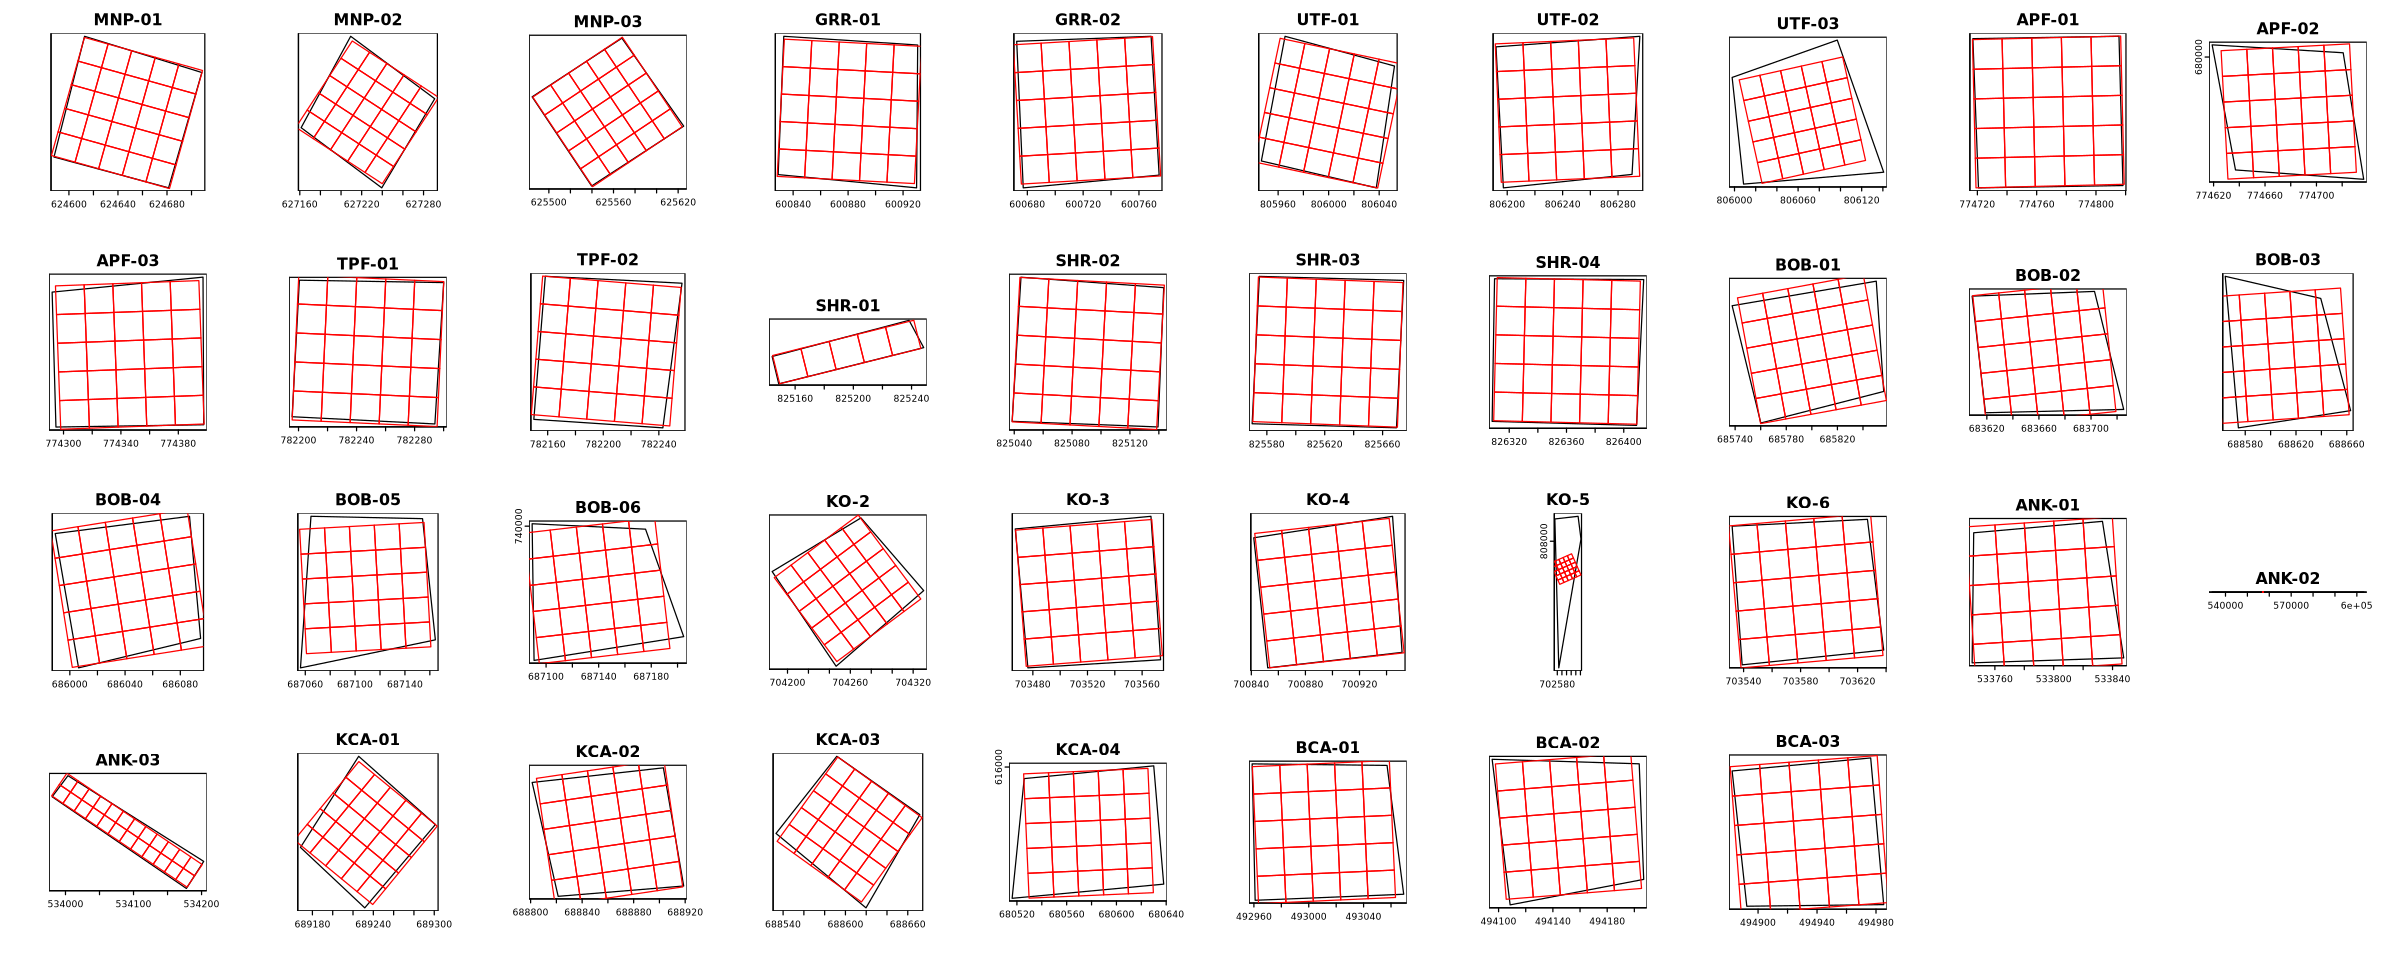

In [18]:
par(mfrow=c(4,10))
options(repr.plot.width=20, repr.plot.height=8)

for(i in unique(plotdata$Site)){
    ii <- plotdata$Site==i
    plot(vect(plotdata$p.geom.corr[ii][1]), main=plotdata$Site[ii][1])
    for(j in 1:nrow(plotdata[ii,])){
        lines(vect(plotdata$sp.geom[ii][j]), col='red')
    }    

}

---
#### Corrections to site IDs to match the tree data frame and calculation of plot and subplot area.

In [19]:

	#Correct site IDs that don't match between plot and tree data
	plotdata$PID <- plotdata$Site
	plotdata$PID[plotdata$Site=="KO-2"] <- "KO-02"
	plotdata$PID[plotdata$Site=="KO-3"] <- "KO-03"
	plotdata$PID[plotdata$Site=="KO-4"] <- "KO-04"
	plotdata$PID[plotdata$Site=="KO-5"] <- "KO-05"
	plotdata$PID[plotdata$Site=="KO-6"] <- "KO-06"
	plotdata$PID[plotdata$Site=="APF-01"] <- "AFR-01"
	plotdata$PID[plotdata$Site=="APF-02"] <- "AFR-02"
	plotdata$PID[plotdata$Site=="APF-03"] <- "AFR-03"

	plotdata <- plotdata[plotdata$PID!="KO-05",]
	plotdata <- plotdata[plotdata$PID!="ANK-02",]

	plotdata$key <- paste(plotdata$PID, plotdata$sp, sep='_')

    # Calculation of plot area
    plotdata$p.area <- 100*100
	plotdata$p.area[plotdata$Site=="SHR-01"] <- 100*20
	plotdata$p.area[plotdata$Site=="ANK-03"] <- 240*40
    plotdata$sp.area <- 20*20


### Global map of plot locations

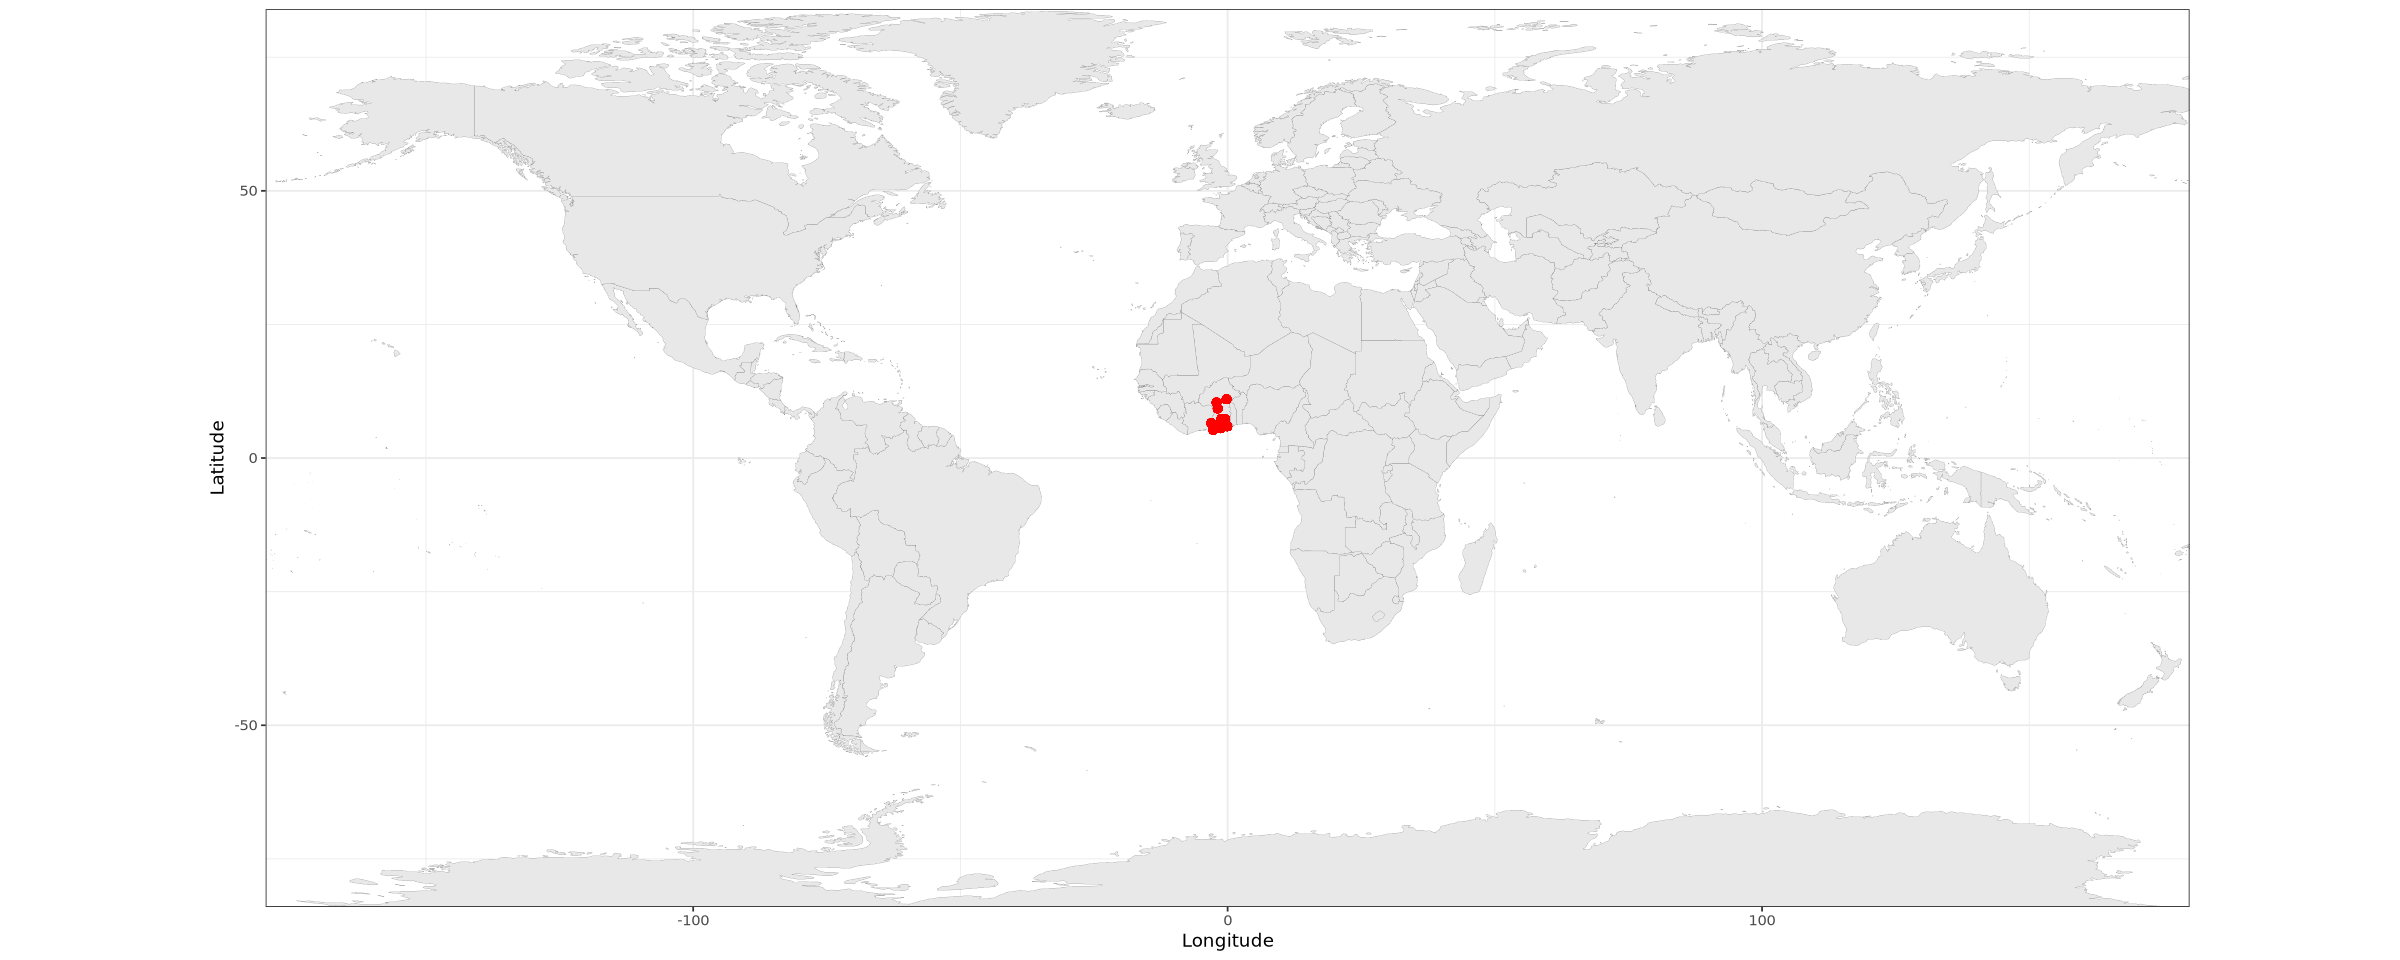

In [20]:
## Map of the world, with points for each plot
## Focal project is in red, other projects in black
	
world <- map_data("world")
gg <- ggplot()
gg <- gg + geom_map(data=world, map=world,
			aes(map_id=region),
			color="#595959", fill="#e8e8e8", linewidth=0.05, alpha=1)
# Focal project in red
gg <- gg + geom_point(data=plotdata, 
				aes(x=lon.cent, y=lat.cent), 
				size=2, alpha=1, color="red")
gg <- gg + theme(legend.position="none",panel.border=element_rect(colour="black",fill=NA,linewidth=0.5)) +  
				labs(x="Longitude",y="Latitude") + coord_equal() + theme_bw() +
				scale_x_continuous(expand = c(0, 0), limits = c(-180, 180)) + 
				scale_y_continuous(expand = c(0, 0), limits = c(-84, 84))  

options(repr.plot.width=20)
gg

### Country map of plot locations

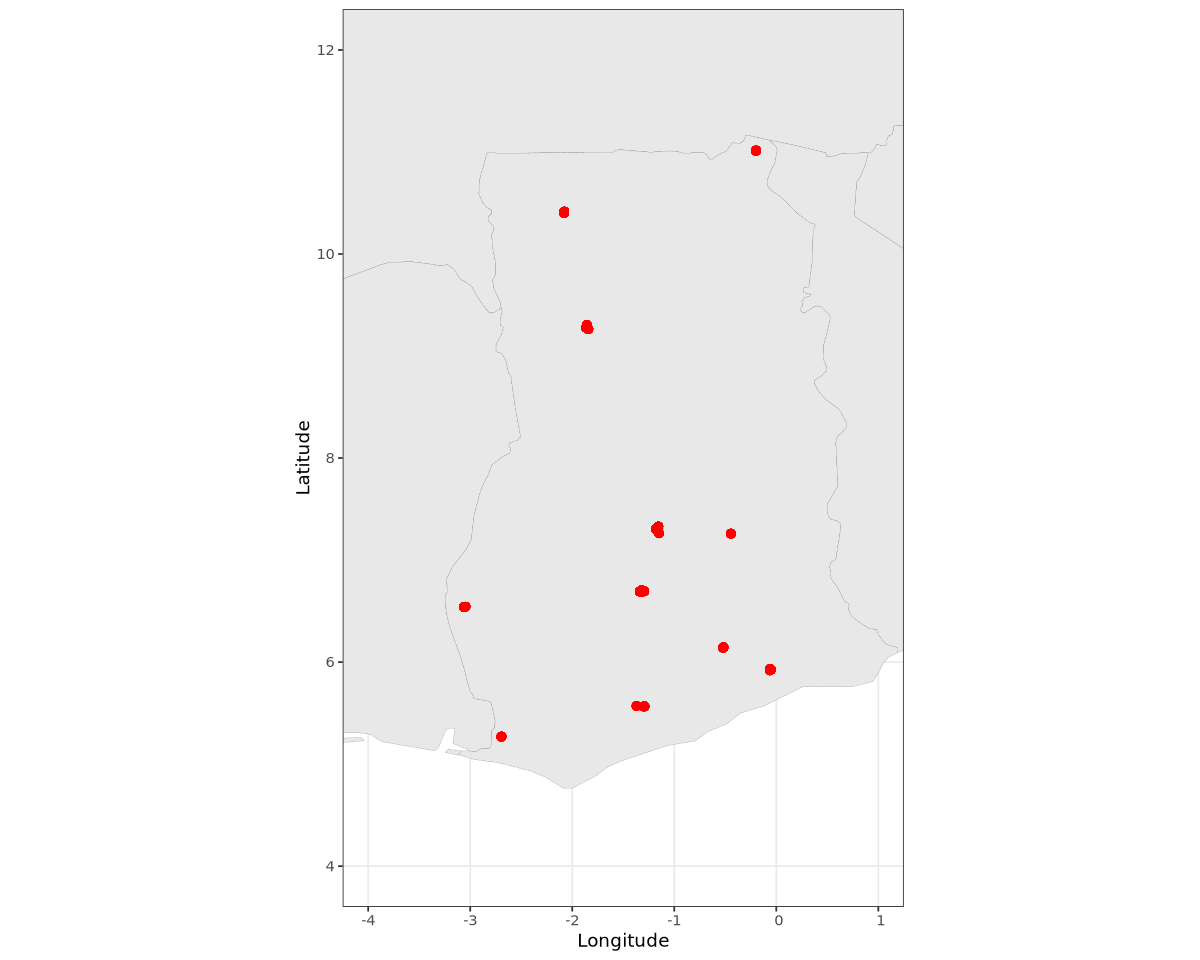

In [21]:

gg <- ggplot()
# Add points for plot locations
gg <- gg + geom_map(data=world, map=world,
			aes(map_id=region),
			color="#595959", fill="#e8e8e8", linewidth=0.05, alpha=1)
gg <- gg + geom_point(data=plotdata, 
					aes(x=lon.cent, y=lat.cent), 
					size=2, alpha=1, color="red")

gg <- gg + theme(legend.position="none",panel.border=element_rect(colour="black",fill=NA,linewidth=0.5)) +  
				labs(x="Longitude",y="Latitude") + theme_bw() + xlim(-4,1) + ylim(4,12) + geom_sf()
options(repr.plot.width=10)
gg



---

## 2. Estimating tree- and plot-level aboveground biomass density (AGBD)

First, load tree data data frame from CSV, which is typically provided by the field team. This includes individual field information which often varies by team but essentially includes information about the site, plot, subplot (if applicable), tree species, Diameter at Breast Height (DBH), and often height. Including measurements of height in the field facilitates quality control checks between field plots and lidar and is highly recommended where possible. 


In [22]:
treedata <- read.csv("/projects/shared-buckets/minord/data/ghana_fao/treeData.csv")
treedata <- treedata[,1:19]
str(treedata)

'data.frame':	15609 obs. of  19 variables:
 $ Date     : chr  "8/5/2023" "8/5/2023" "8/5/2023" "8/5/2023" ...
 $ Ecozone  : chr  "GS" "GS" "GS" "GS" ...
 $ Site     : chr  "Gbele Resource Reserve" "Gbele Resource Reserve" "Gbele Resource Reserve" "Gbele Resource Reserve" ...
 $ PID      : chr  "GRR-01" "GRR-01" "GRR-01" "GRR-01" ...
 $ PT       : chr  "MP" "MP" "MP" "MP" ...
 $ Subplot  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Tag      : chr  "2235A" "2235B" "2236" "2237" ...
 $ Tnb      : chr  "" "" "" "" ...
 $ Species  : chr  "Combretum nigricans" "Combretum nigricans" "Vitellaria paradoxa" "Vitellaria paradoxa" ...
 $ COR.N    : num  10.4 10.4 10.4 10.4 10.4 ...
 $ COR.W    : num  2.08 2.08 2.08 2.08 2.08 ...
 $ ELEV     : chr  "215" "215" "219" "216" ...
 $ WD       : num  0.79 0.79 0.738 0.738 0.738 ...
 $ dbh..cm. : num  16.8 14.6 20.5 14.6 10.6 14 12.4 11.1 61 19 ...
 $ H..m.    : num  7 10.3 15.3 6.5 6.3 6.1 6.4 5 24.6 10 ...
 $ H.Mode   : chr  "MH" "MH" "MH" "MH" ...
 $ Mass.kg.C: n

#### Select tree measurements to be used in AGBD calculation
Plot measurements have two plot types (column 'PT') - main plot  ('MP') and smaller plot ('SP') which were 5 10m x 10m plots nested within the main plot. For the AGBD calculation, we will use the main plot data

We will only use trees that are greater than 10 cm in diameter at breast height (DBH).

In [23]:
treedata <- treedata[treedata$PT =='MP',]
treedata <- treedata[treedata$dbh..cm.>=10,]

	
# Remove rows indicating "No Tree in subplot"
treedata <- treedata[treedata[,"Life.Form"] != 'NT',]
cat(nrow(treedata), 'tree measurements across all plots')

13267 tree measurements across all plots

---

#### Prepare the tree data for aboveground biomass estimation
Ofen there will be formatting in the plot or tree csv files from field teams that need to be changed for use of programming languages such as R or python. This eample uses R to estimate AGBD, and the format of the dates needed to be changed.

In [24]:
# Correct date formats to a consistent format
# Insert final date of data collection for missing dates
ii <- grepl(pattern="/23", x=treedata$Date)
treedata$date[ii] <- as.character(as.Date(treedata$Date[ii], format = "%d/%m/%y"))
ii <- grepl(pattern="/2023", x=treedata$Date)
treedata$date[ii] <- as.character(as.Date(treedata$Date[ii], format = "%d/%m/%Y"))
ii <- is.na(treedata$Date)
treedata$date[ii] <- as.character(as.Date("30/06/2023", format = "%d/%m/%Y"))
treedata$tree.date <- treedata$date
	

#### Separate measured and modeled tree heights
Some trees are measured directly in the the field and provided in the tree dataset. Some are not, and are either modelled by the field team as a function typically of DBH and species, or can be modeled by other researchers. In this example h.t.mod is modeled tree height. Some biomass algorithms use tree height as well as DBH as predictors. 

In [25]:
# Measured tree heights	
treedata$h.t <- NA
treedata$h.t[treedata$H.Mode == 'MH' & !is.na(treedata$H.Mode)] <- treedata$H..m.[treedata$H.Mode == 'MH' & !is.na(treedata$H.Mode)]

# Modeled tree heights
treedata$h.t.mod <- NA
treedata$h.t.mod[treedata$H.Mode == 'PH' & !is.na(treedata$H.Mode)] <- treedata$H..m.[treedata$H.Mode == 'PH' & !is.na(treedata$H.Mode)]

# Designate alive/dead status of trees as 1 (alive) or 0 (dead)
treedata$status <- as.numeric(treedata$Status=="Alive")
treedata <- treedata[treedata$status == 1,]
treedata$species <- treedata$Species

#### Combine tree and plot data tables

In [26]:
# Combine plot and subplot ID to have a key for joining the plot and tree data frames
treedata$key <- paste(treedata$PID, treedata$Subplot, sep='_')

# Join together join the plot and tree
data <- plyr::join(plotdata, treedata, by="key", type="left", match="all")


---

#### Check a species names.
Species names are looked up from an online database. Any variation in spelling is corrected. This can be a time consuming step but is important. Here we use the BIOMASS package in R to correct for species names in the tree dataset. More information on this package can be found here: https://cran.r-project.org/web/packages/BIOMASS/index.html

In [27]:
data$species[data$species %in% c('unidentified', 'YET TB IDENTIFIED','YTBI','Yet to be identified','Yet to be identified') ] <- NA   
ii <- !duplicated( data[,"species"] ) & !is.na(data[,"species"])
species <- unlist( lapply(data$species[ii], function(x) strsplit(x," ")[[1]][2]) )
genus <- unlist( lapply(data$species[ii], function(x) strsplit(x," ")[[1]][1]) )
    

In [28]:
taxo <- BIOMASS::correctTaxo(genus=genus, species=species) 

Using useCache=TRUE is recommended to reduce online search time for the next query



  |======================================================================| 100%


Source iplant_tnrs:753, NA:4

Corrections FALSE:472, TRUE:150, NA:4, SpNotFound:92, TaxaNotFound:19, NoMatch(low_score):20



In [29]:
apg <- BIOMASS::getTaxonomy(taxo$genusCorrected, findOrder=FALSE) 
str(apg)

'data.frame':	757 obs. of  2 variables:
 $ inputGenus: chr  "Anogeissus" "Combretum" "Crossopteryx" "Terminalia" ...
 $ family    : chr  "Combretaceae" "Combretaceae" "Rubiaceae" "Combretaceae" ...


In [30]:
taxon.data <- data.frame(species=data$species[ii], new.family=unlist(apg$family),
            new.genus=unlist(taxo$genusCorrected), new.species=unlist(taxo$speciesCorrected))

In [31]:
newdata <- plyr::join(data, taxon.data, by=c("species"), type="left", match="all")
data$species <- sprintf("%s %s", newdata$new.genus, newdata$new.species)
data$family <- newdata$new.family

#### Genus and species is used to look up wood specific gravity.
In theory biomass is a function of tree size and wood density. Tree size, if trees are perfect cylinders, would just be stem 3.14 (pi) x stem radius ^2 x tree height. Of course trees are not perfect cylinders, and allometric models relate measurements of trees from the field to their biomass. The BIOMASS package is also used here to get an estimate of wood density for each tree based on its species.

In [32]:
    
species <- unlist( lapply(data$species, function(x) strsplit(x," ")[[1]][2]) )
genus <- unlist( lapply(data$species, function(x) strsplit(x," ")[[1]][1]) )
                    

invisible(capture.output( dataWD <- BIOMASS::getWoodDensity(genus = genus,
                                      species = species,
                                      family = data$family) ))
    
data$wsg <- dataWD$meanWD
data$wsg.sd <- dataWD$sdWD


The reference dataset contains 16467 wood density values

Your taxonomic table contains 551 taxa



#### For trees without measured heights, fill in modeled height based on height and diameter relationship from tree that do have measured heights
We use biomass allometric models from the BIOMASS package that estimate agb as a function of both DBH and height; where height measurements are not available, we estimate them as a function of DBH.

In [33]:
  
ii <- is.na(data$h.t) & !is.na(data$dbh..cm.) & (data$dbh..cm. > 0)
if ( any(ii, na.rm=TRUE) ) {
    jj <- !is.na(data$dbh..cm.) & !is.na(data$h.t) & (data$dbh..cm. > 0) & (data$h.t > 0)
    if ( any(jj, na.rm=TRUE) ) {
        HDmodel <- BIOMASS::modelHD(D=data$dbh..cm.[jj], H=data$h.t[jj], useWeight=TRUE, 
                                    method='log1')
        HDest <- BIOMASS::retrieveH(D=data$dbh..cm., model=HDmodel)
        data$h.t.mod <- HDest$H
        errH <- HDest$RSE

     }
}

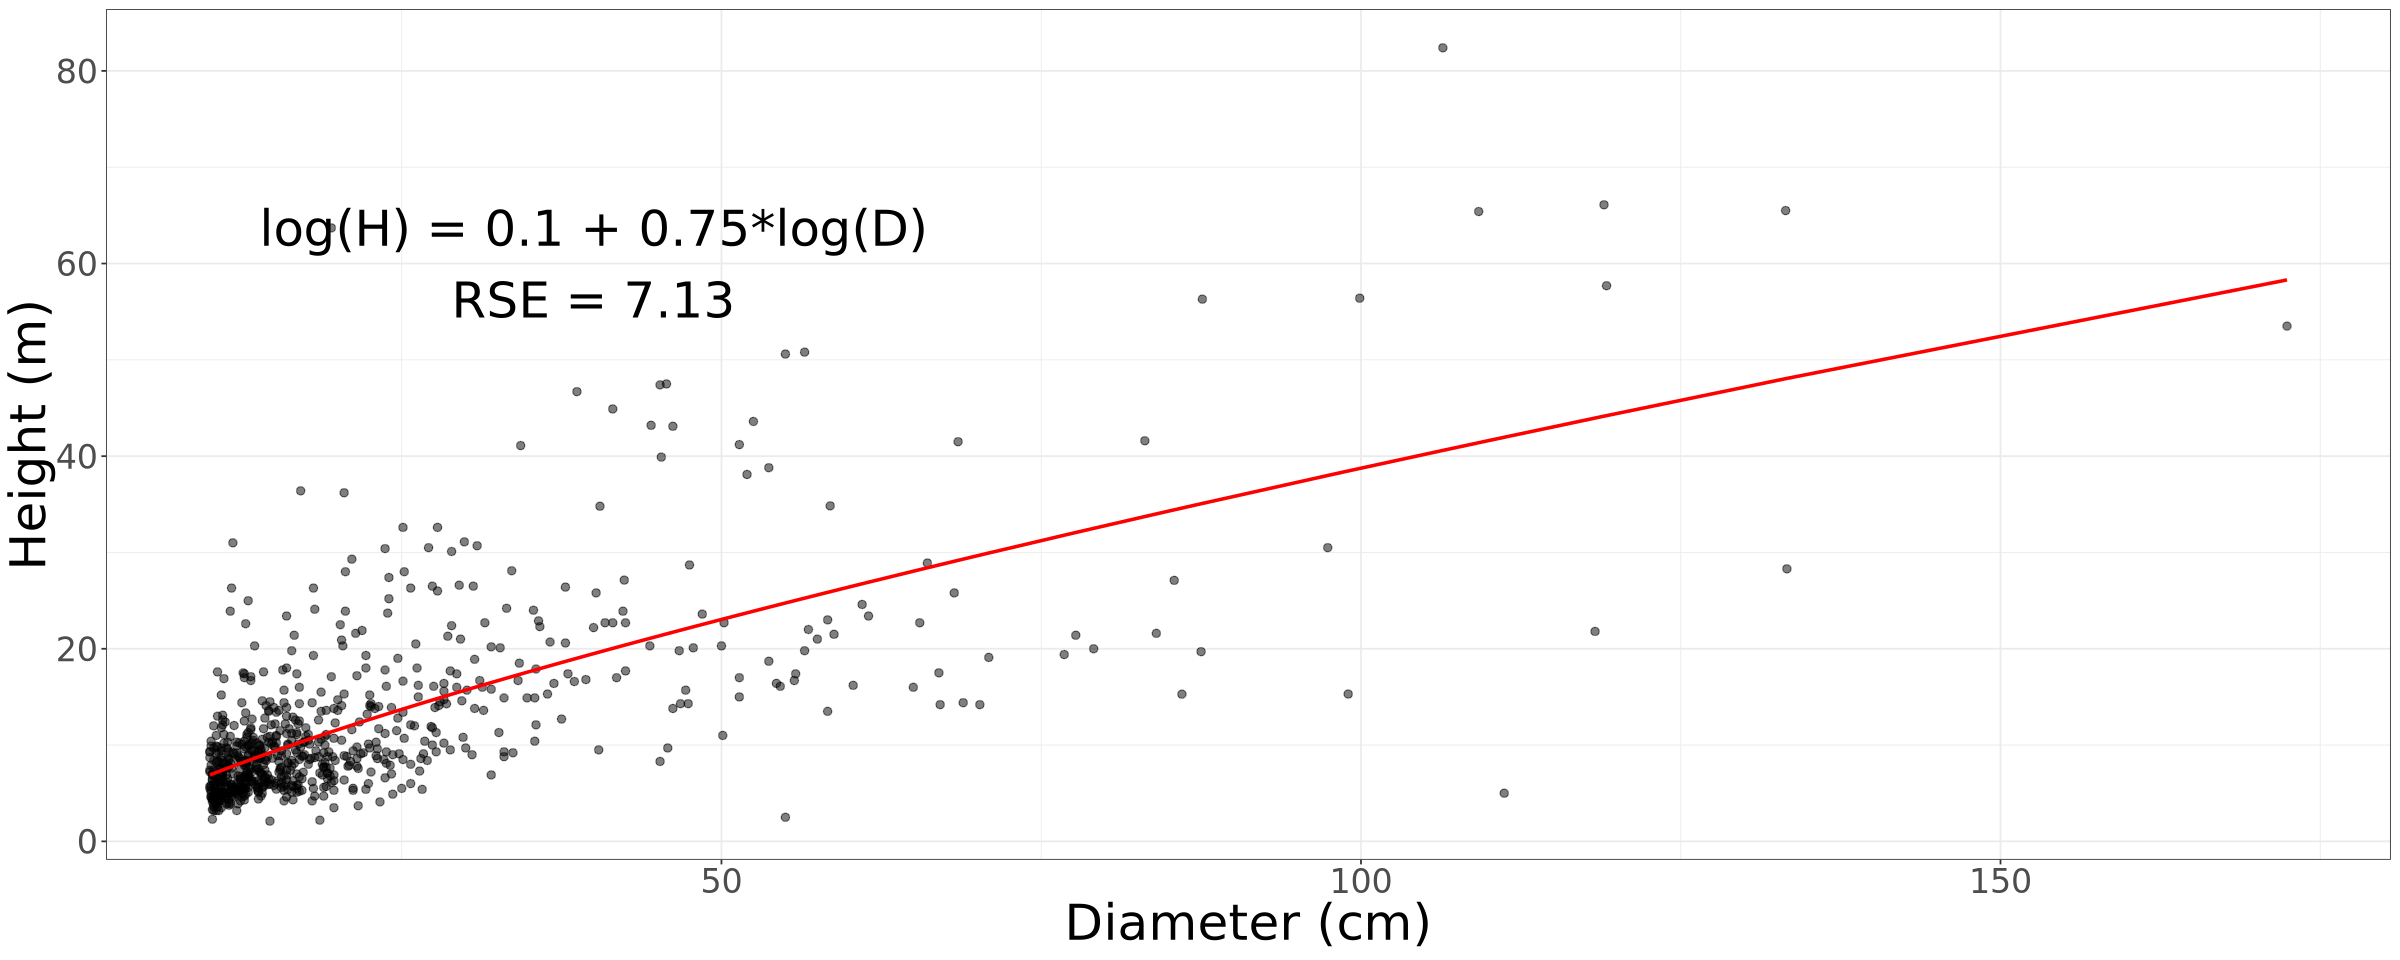

In [34]:
ii <- !is.na(data[,'h.t']) & !is.na(data[,'dbh..cm.']) & (data[,'status']==1 | is.na(data[,'status']))
intercept <- HDmodel$model$coefficients[1]
coef <- HDmodel$model$coefficients[2]

gg <- ggplot()
gg <- gg + geom_point(data=data[ii,c('dbh..cm.', 'h.t', 'h.t.mod')], 
				aes(dbh..cm., y=h.t), 
				size=2, alpha=0.5, color="black")
if(any(!is.na(data$h.t.mod[ii]))){
		gg <- gg + geom_line(data=data[ii,c('dbh..cm.', 'h.t', 'h.t.mod')], 
				aes(dbh..cm., h.t.mod), 
				linewidth=1, alpha=1, color="red")
}
gg <- gg + labs(x='Diameter (cm)',y='Height (m)') + theme_bw() + theme(axis.title=element_text(size=30), axis.text = element_text(size = 20))
gg <- gg + annotate('text', x = 40, y = 60, size=10.5, label = paste0('log(H) = ',round(intercept,2),' + ', round(coef,2),'*log(D)\nRSE = ',round(HDmodel$RSE,2), sep=''))

options(repr.plot.width=20)
gg

In [35]:
str(data[ii,c('dbh..cm.', 'h.t', 'h.t.mod')])

'data.frame':	741 obs. of  3 variables:
 $ dbh..cm.: num  14.2 14 19.2 11.4 18.9 13.5 23.1 25 26.3 11.7 ...
 $ h.t     : num  11.7 8.7 6.5 10.3 9.2 8.8 8.6 5.5 15 5.6 ...
 $ h.t.mod : num  8.97 8.87 11.24 7.6 11.11 ...


### Calculate tree level biomass based on tree diameter, height, and wood specific gravity
Again the BIOMASS package in R is used to estimate biomass (agb) for every tree

In [36]:
h.t.tmp <- data$h.t
jj <- is.na(h.t.tmp) | (h.t.tmp <= 0)
h.t.tmp[jj] <- data$h.t.mod[jj]
ii <- !is.na(data[,'dbh..cm.']) & (data[,'status']==1 | is.na(data[,'status']))

data$m.agb[ii] <- BIOMASS::computeAGB(data$dbh..cm.[ii], data$wsg[ii], H=h.t.tmp[ii]) * 1e3
   

### Calculate subplot AGBD based on the sum of tree AGB divided by subplot area
Individual tree agb is turned into agb density for each subplot by simply adding up the total biomass (agb) of all trees and dividing by the area of the subplot

In [37]:
plotAGB_generic <- function(data) {
  
  agb <- sum(data$m.agb, na.rm=TRUE)
  agb <- ifelse(is.na(agb), 0, agb)

  agbd.ha <- sum( ( (data$m.agb / 1e3) / (data$sp.area / data$p.area) ) / (data$p.area / 1e4), na.rm=TRUE)
  

  data.frame(plot=data$PID[1], subplot=data$Subplot[1],
             agb=agb, agbd.ha=agbd.ha)
}

## Look at Output Data
Here we look at the structure of the new dataset, which has the plot ID, subplot, and total agb as well as agbd (Mg/ha, called agbd.ha here). AGBD is the final attribute we want, as this is what biomass products estimate and we want to ultimately have agbd maps for countries. We also see from the histogram of the predicted agbd from the Ghana field data that these values are reasonably. Typically forests have many small AGBD plots and a few larger AGBD plots. Note that at this high spatial scale (~20 m subplots) very large (>1000 Mg/ha) values of AGBD are possible. These are not errors, but subplots where large trees are clustered and when dividing by the small area, AGBD values are high. If these subplots are combined to 1 ha plots it is rare to see values >1000 Mg/ha (although possible in very high biomass forests!)

In [38]:
newdata <- plyr::ddply(data, c("PID","Subplot"), plotAGB_generic)

str(newdata)

'data.frame':	855 obs. of  6 variables:
 $ PID    : chr  "AFR-01" "AFR-01" "AFR-01" "AFR-01" ...
 $ Subplot: int  1 2 3 4 5 6 7 8 9 10 ...
 $ plot   : chr  "AFR-01" "AFR-01" "AFR-01" "AFR-01" ...
 $ subplot: int  1 2 3 4 5 6 7 8 9 10 ...
 $ agb    : num  14432 1888 1584 4937 13803 ...
 $ agbd.ha: num  360.8 47.2 39.6 123.4 345.1 ...


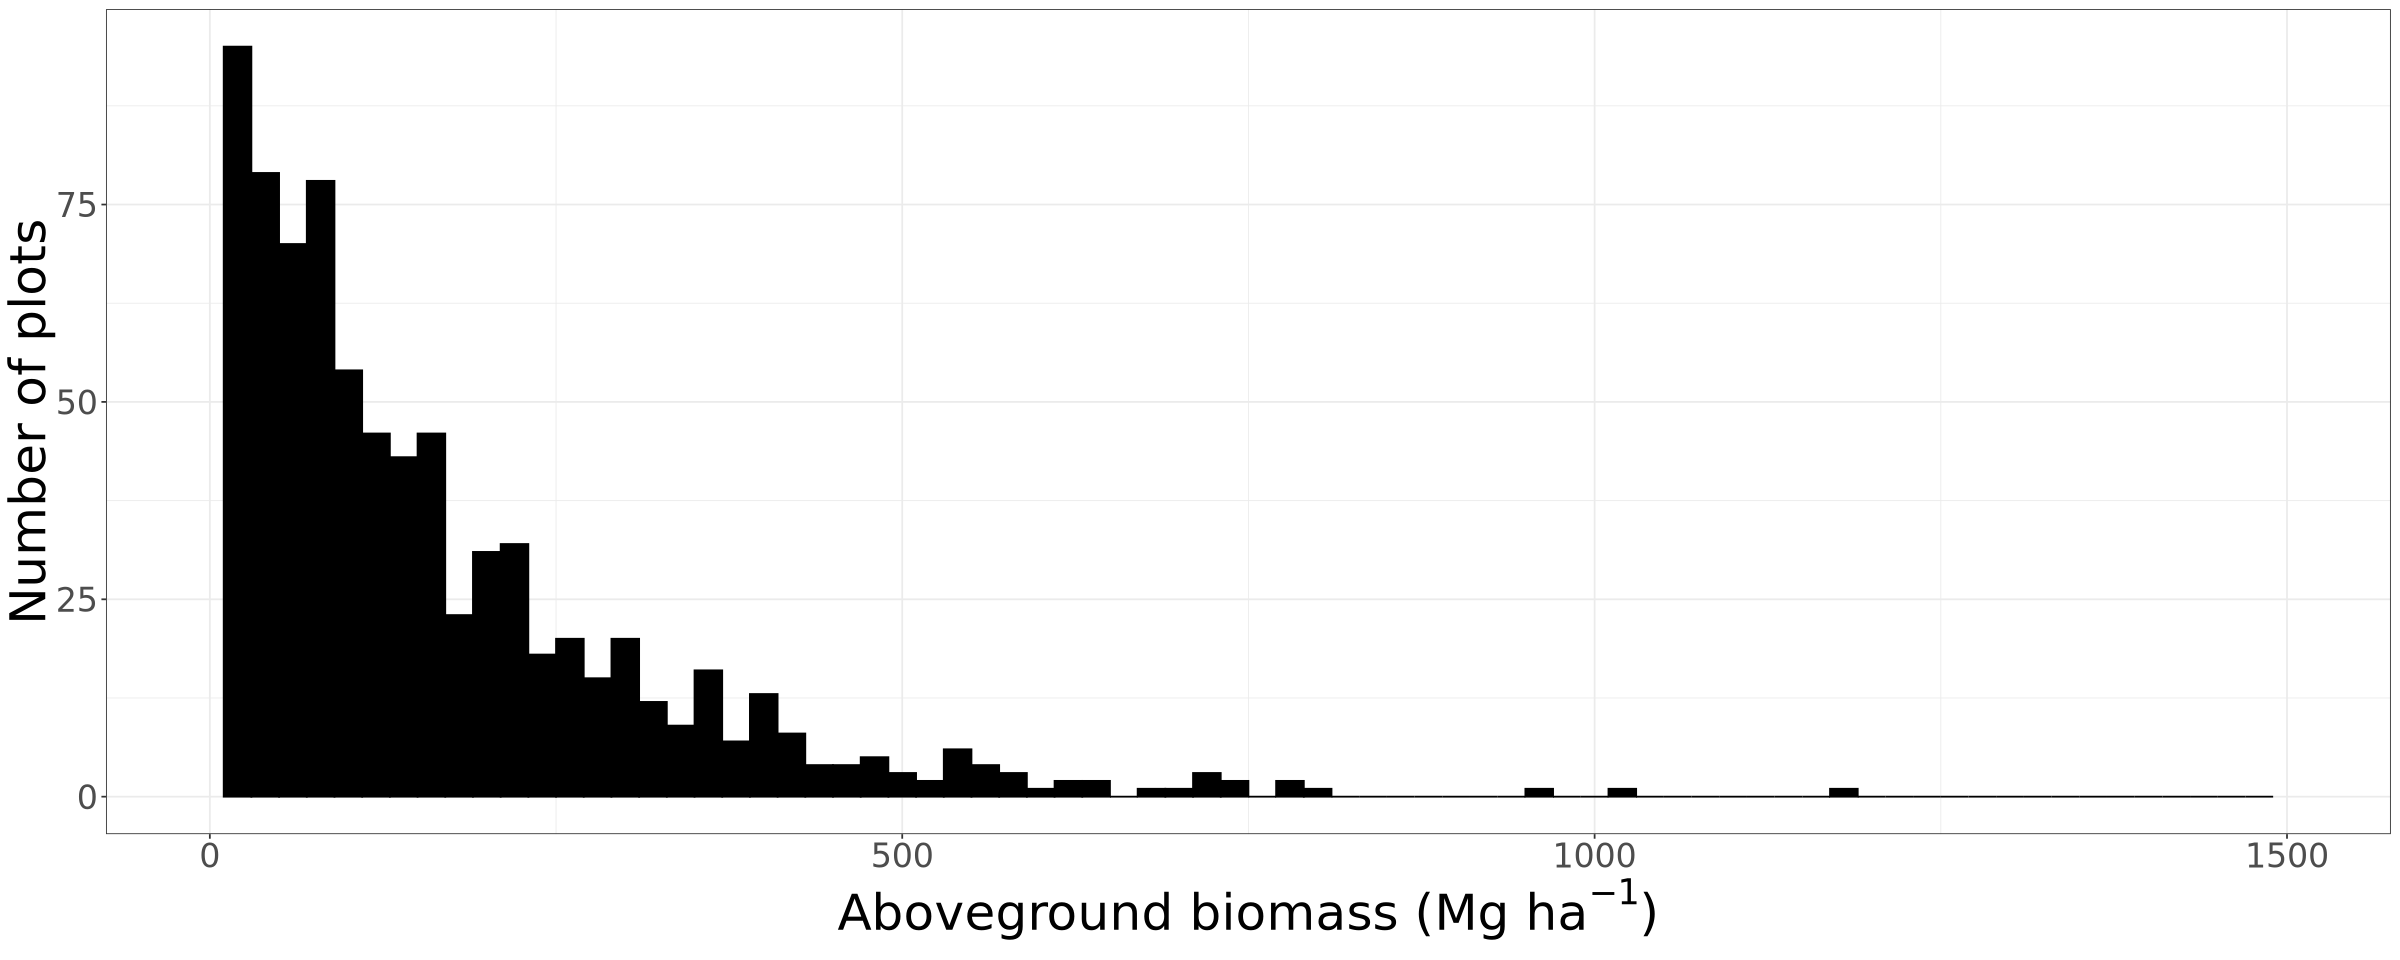

In [39]:
## Plot histograms of aboveground biomass
## First plot is hisogram of aboveground biomass at native subplot scale
ii <- !is.na(newdata$agbd.ha)
p1 <- ggplot(data=newdata[ii,], aes(agbd.ha))
p1 <- p1 + geom_histogram(binwidth=20, color="black", fill="black") + xlim(0,1500) + 
				labs(x=bquote('Aboveground biomass (Mg' ~ha^-1*")"),y="Number of plots") + 
				theme_bw() + theme(axis.title=element_text(size=30), , axis.text = element_text(size = 20))
options(warn=-1)
p1

---

## 3. Processing airborne lidar over plots simulate GEDI footprints and link to plot-level AGBD estimates
Airborne lidar processing requires lastools and gedisimulator software, so this section will be a demonstration of the process, rather than actual data processing. The GEDI simulator is freely available and documented by the following link. Lastools has a public version with some capability, but a license is often needed for more in depth applications. Note that lidar processing workflows continue to evolve and hopefully fully open workflows will soon be available. However we recommend collaborating with a lidar research group or company in the processing of airborne lidar, either for GEDI simulation or another purpose. The following general steps are intended for transparency and educational purposes.

---
#### lastools: https://rapidlasso.de/downloads/
---
#### gedisimulator: https://bitbucket.org/StevenHancock/gedisimulator/src/master/

---
The first step in airborne lidar processing is to categorize the lidar pointclound in to ground and canopy. This is done using the lastools lasground function.

Using plot BOB-05 as an example, the ground points are separated from canopy, resulting in the digital elevation model below. The subplot geometry is superimposed in white.

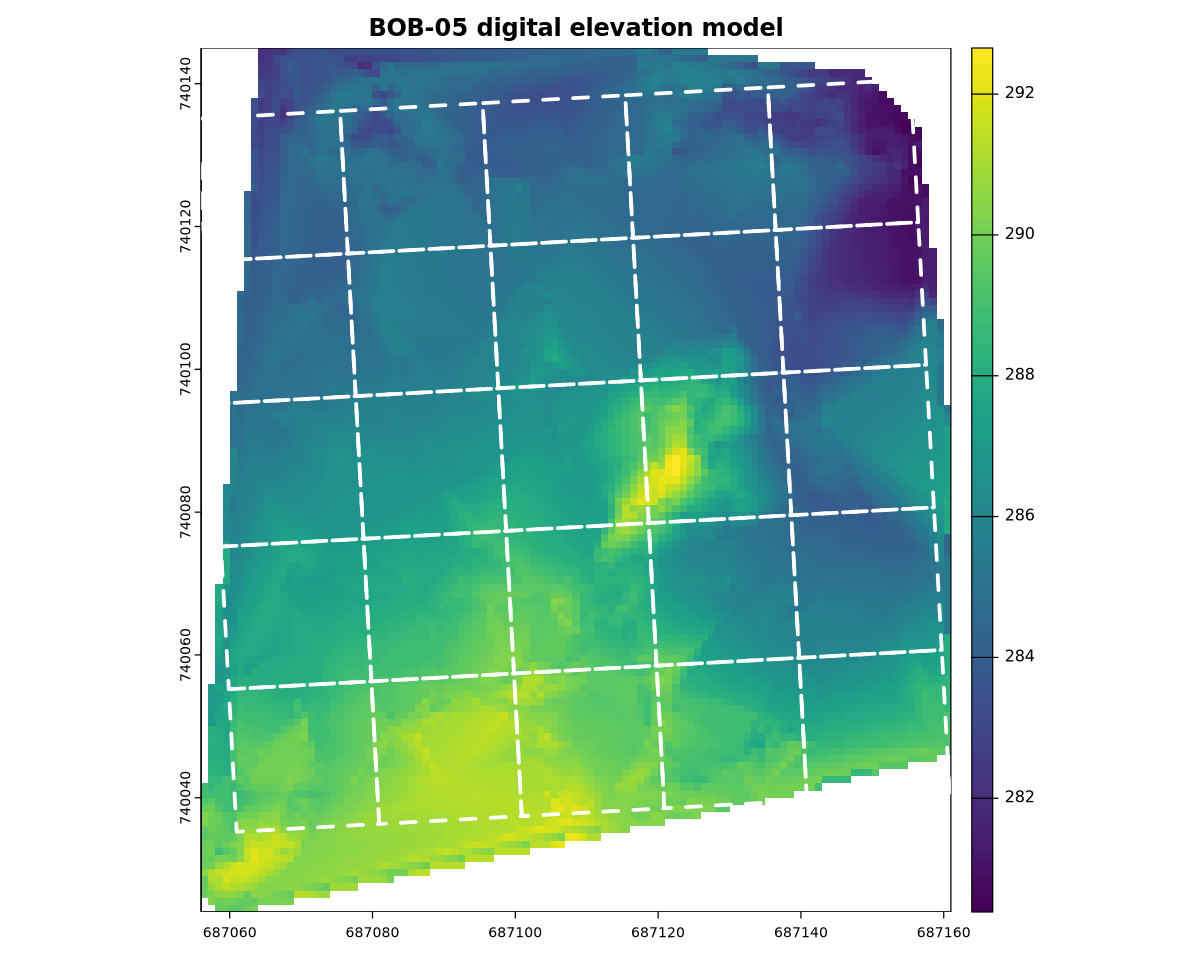

In [40]:
dem_BOB_05 <- terra::rast("/projects/shared-buckets/minord/data/ghana_fao/BOB05_dem.tif")

options(repr.plot.width=10)
plot(dem_BOB_05, main="BOB-05 digital elevation model")
ii <- plotdata$Site=="BOB-05"
for(j in 1:nrow(plotdata[ii,])){
       lines(vect(plotdata$sp.geom[ii][j]), col='white', lty=2, lwd=3)
} 

#### Simulated GEDI waveforms
GEDI-based estimates of AGBD need to be applied to on-orbit GEDI waveforms. However for many reasons, collocating GEDI samples with field plots is challenging or sometimes impossible. Therefore GEDI's AGBD models are based on using airborne lidar to simulate GEDI waveforms, and building models predicting biomass as a function simulated GEDI waveform metrics. Therefore we need to simulate GEDI waveform metrics over subplots. 

The figure below shows the canopy height map from the airborne lidar for plot BOB-05, with the subplot geometry superimposed in white.

The cyan circle represents the locations of the GEDI footprint simulated from the airborne lidar pointcloud, resulting in the simulated waveform in the center panel. From the simulated waveform, relative height (RH) metrics are calculated, which are used in the biomass modeling in the next notebook. 

RH metrics are the heights below which some percentage of waveform energy has been reflected relative to the estimated ground elevation from the waveform. In the plots below the black lines represent simulated waveforms, and the simulated RH metrics are plotted next to them. Think of these waveforms like vertical profiles of a forest, if looking at the forest from the side. The first (highest) peak typically represents the top of the canopy, the last (lowest) peak typically represents the ground elevation. The distance between the first and last peak is the maximum canopy height (RH98, or the height below which 98% of canopy energy is reflected).

In [41]:
footprint_BOB_05 <- png::readPNG("/projects/shared-buckets/minord/data/ghana_fao/ghana_fao_footprintplot-BOB-05.png")


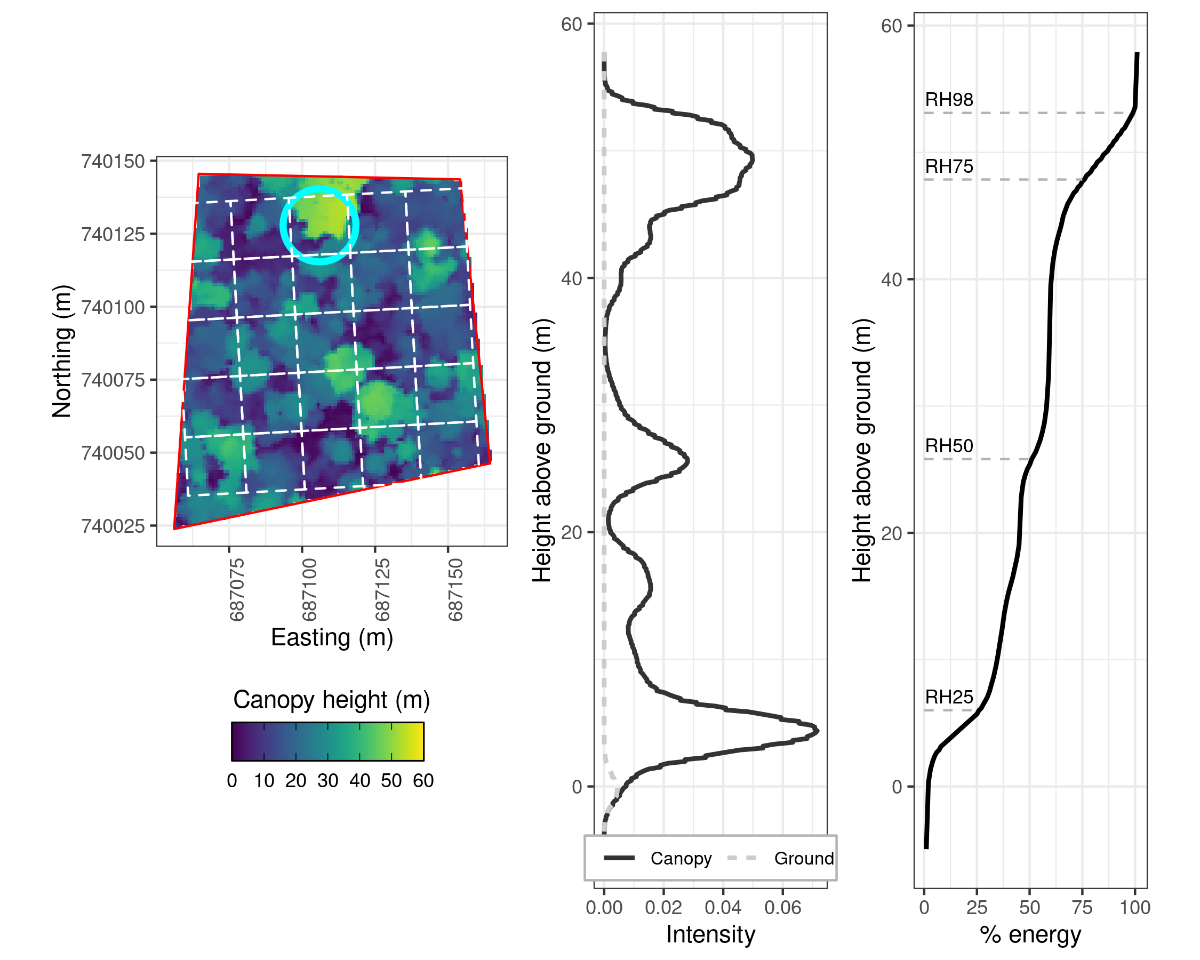

In [42]:
options(repr.plot.width=10)
grid::grid.raster(footprint_BOB_05)


Below are two additional examples of simulated GEDI footprints over plots GRR-01 and KCA-02.

In [43]:
footprint_GRR_01 <- png::readPNG("/projects/shared-buckets/minord/data/ghana_fao/ghana_fao_footprintplot-GRR-01.png")
footprint_KCA_02 <- png::readPNG("/projects/shared-buckets/minord/data/ghana_fao/ghana_fao_footprintplot-KCA-02.png")

## Visualizing a Simple Canopy
This waveforms only has two peaks - the first is from the canopy, the second from the ground. The center of the second peak is set to a height of 0 as it is the ground, and the RH98 here is around 22 m above that ground elevation. If this subplot has many trees at different heights it would likely have multiple peaks.

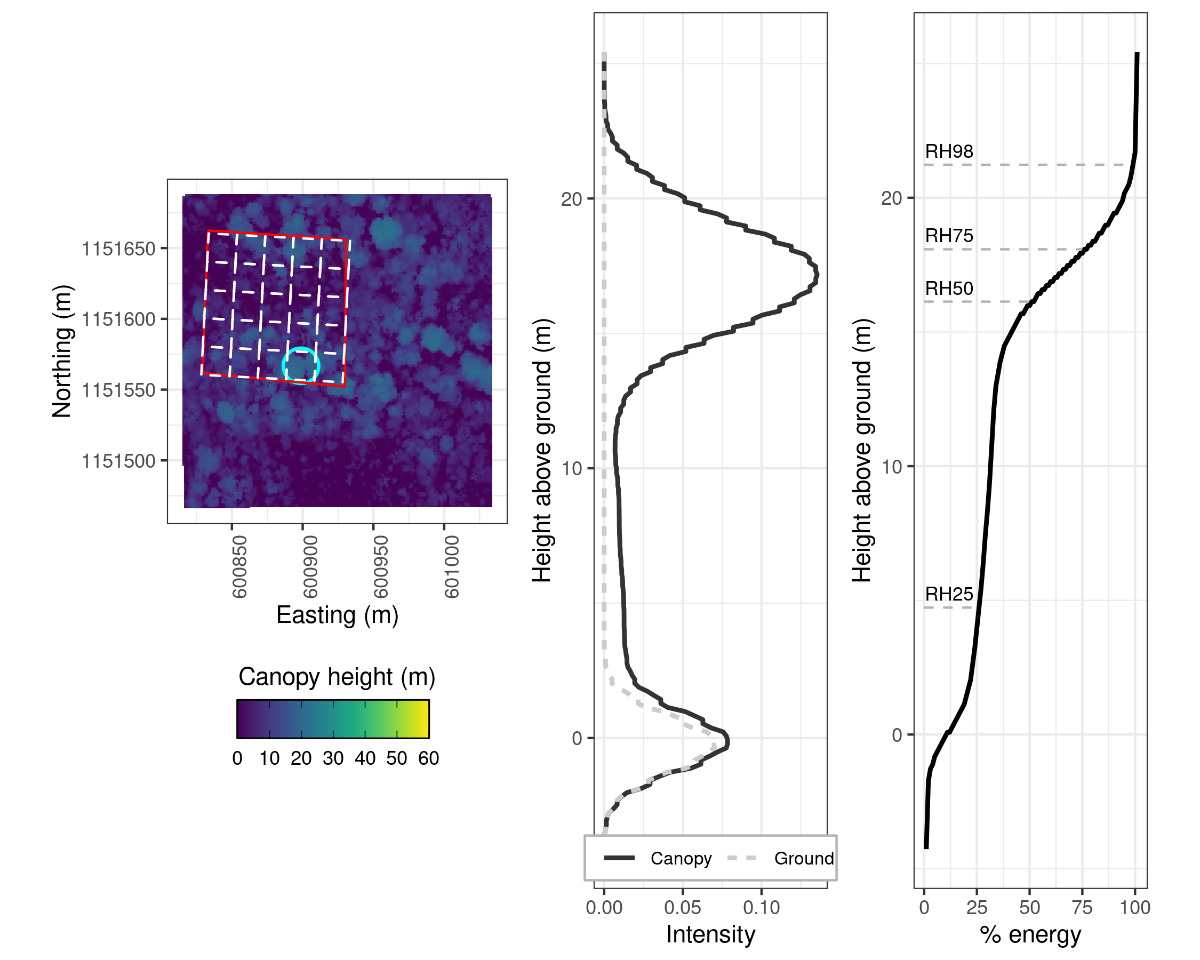

In [44]:
options(repr.plot.width=10)
grid::grid.raster(footprint_GRR_01)


## Visualizing a Complicated Canopy
The following waveform is from a taller, denser forest with a more complicated vertical structure. There may also be some slope, as the ground peak appears stretched out. There is likely some understory and midstory as well as multiple taller trees in the 20 m plot. RH 98 here is just over 50 m tall.

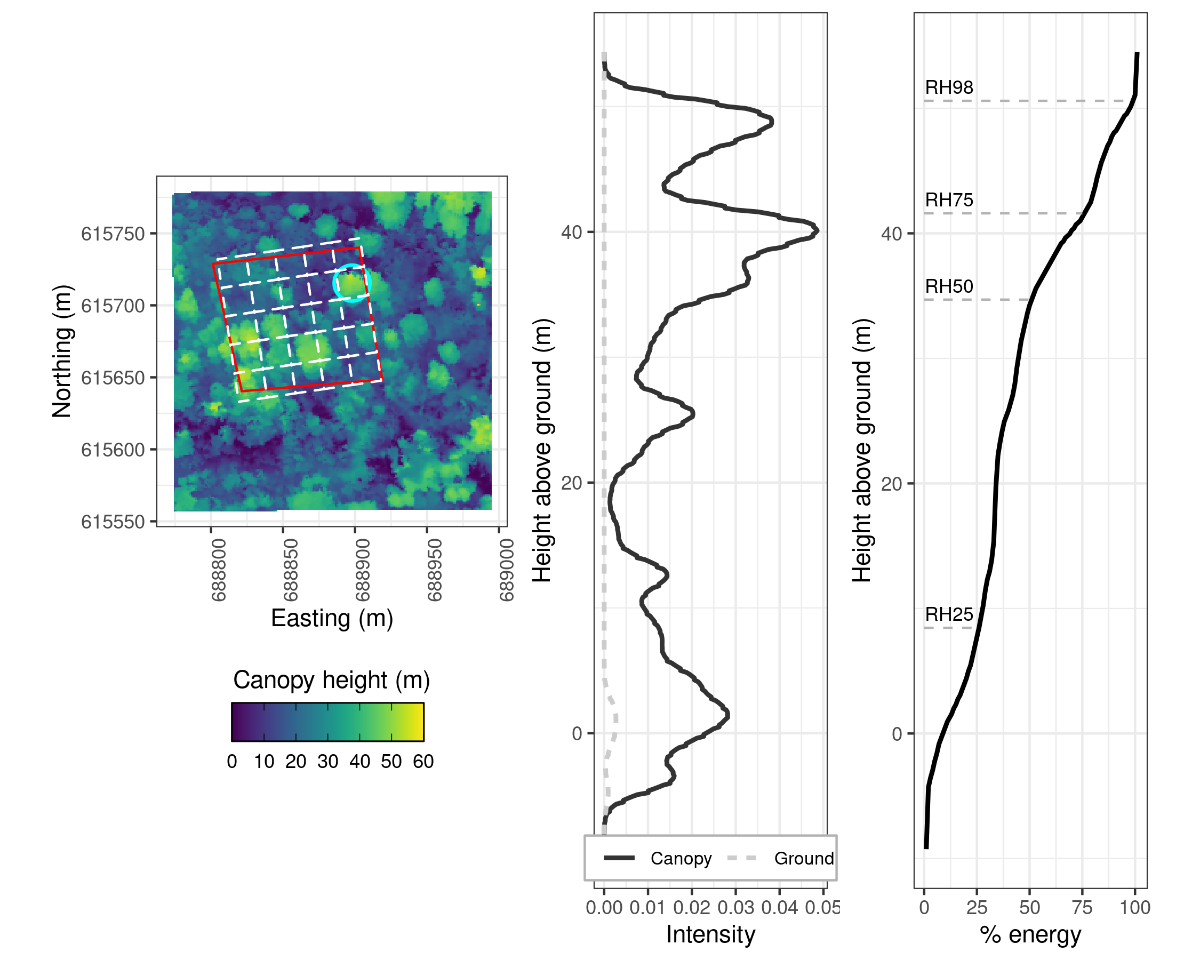

In [45]:
options(repr.plot.width=10)
grid::grid.raster(footprint_KCA_02)


## Output Dataframe for Modeling
When satisfied that there are no errors in the database, the simulated RH metrics and estimated subplot agbd are output into a new database for modeling. We typically use rds or csv files for this. 

Note because this notebook did not show the calculation of the RH metrics from the simulator, the below would only output the agbd dataframe. However the 

In [ ]:
out_filename <- "/projects/my-public-bucket/FAO_WestAfrica/GEDICalValSingleFootprintAll_gedicalvaldata_2024ghana05m_project_aggressive_filter.csv"
write.csv(newdata, out_filename)

In [46]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/r/lib/libopenblasp-r0.3.29.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: US/Pacific
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1  BIOMASS_2.1.11 terra_1.7-78  

loaded via a namespace (and not attached):
 [1] gtable_0.3.6       jsonlite_1.9.0     dplyr_1.1.4        compiler_4.3.3    
 [5] crayon_1.5.3       maps_3.4.2.1       tidyselect_1.2.1   Rcpp_1.0.14       
 [9] minpack.lm_1.2-4   IRdisplay_1.1      png_0.1-8          scales_1.3